# Extract the spectrum of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne and Jérémy Neveu
- date   : May 31st 2017


- The goal is to extract the spectrum after the rotation.


-1) First the 1 orders are extracted. One must check the rotation is correct

-2) Check the 2 orders are well aligned along X by looking at the transverse profile : if you see two peaks this means the rotation is bad.

-3) For this the central star light must having been turned off.

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

Extract_Spectrum


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import sys
sys.path.append("../../common_tools/")
from scan_holo import *

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from matplotlib import cm

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [15]:
def subplots_adjust(*args, **kwargs):
    """
    call signature::

      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)

    Tune the subplot layout via the
    :class:`matplotlib.figure.SubplotParams` mechanism.  The parameter
    meanings (and suggested defaults) are::

      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for blank space between subplots
      hspace = 0.2   # the amount of height reserved for white space between subplots

    The actual defaults are controlled by the rc file
    """
    fig = gcf()
    fig.subplots_adjust(*args, **kwargs)
    draw_if_interactive()

### Output directory for images generated in the notebook view (not true fits images)

In [16]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [17]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [18]:
inputdir="./rotated_fitsimages"
MIN_IMGNUMBER=51
MAX_IMGNUMBER=55
object_name='HD111980 May 31st 2017'
SelectTagRe='^rotimg_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^rotimg_20170531_[0-9]+.fits$'
NBIMGPERROW=2

### output fits file

In [19]:
outputdir="./spectrum_fitsspec"

In [20]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [21]:
input_filelist=os.listdir(inputdir) 

In [22]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [23]:
input_filelist[:5]
print len(input_filelist)

5


In [24]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [25]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [26]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [27]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [28]:
print indexes_files

[51 52 53 54 55]


In [29]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [30]:
sorted_numbers=indexes_files[sorted_indexes]

In [31]:
print sorted_indexes

[0 1 2 3 4]


In [32]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [33]:
#sorted_files

## Build full filename
----------------------------

In [34]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [35]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [36]:
print sorted_filenames.shape

(5,)


## Acces to data of  images
----------------------------------

In [37]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt= []

In [38]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS'].split(' ')[1]
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [39]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [40]:
len(all_images)

5

In [41]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
    
right_edge = 1800    

def ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    It returns the x0, where the maximum occurs in the image
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
  
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        image = all_images[index][:,0:right_edge]
        xprofile=np.sum(image,axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(image,origin='lower',cmap='rainbow',vmin=0,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,275.,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'intput_images.pdf')
    plt.savefig(figfilename)  
    
    return thex0

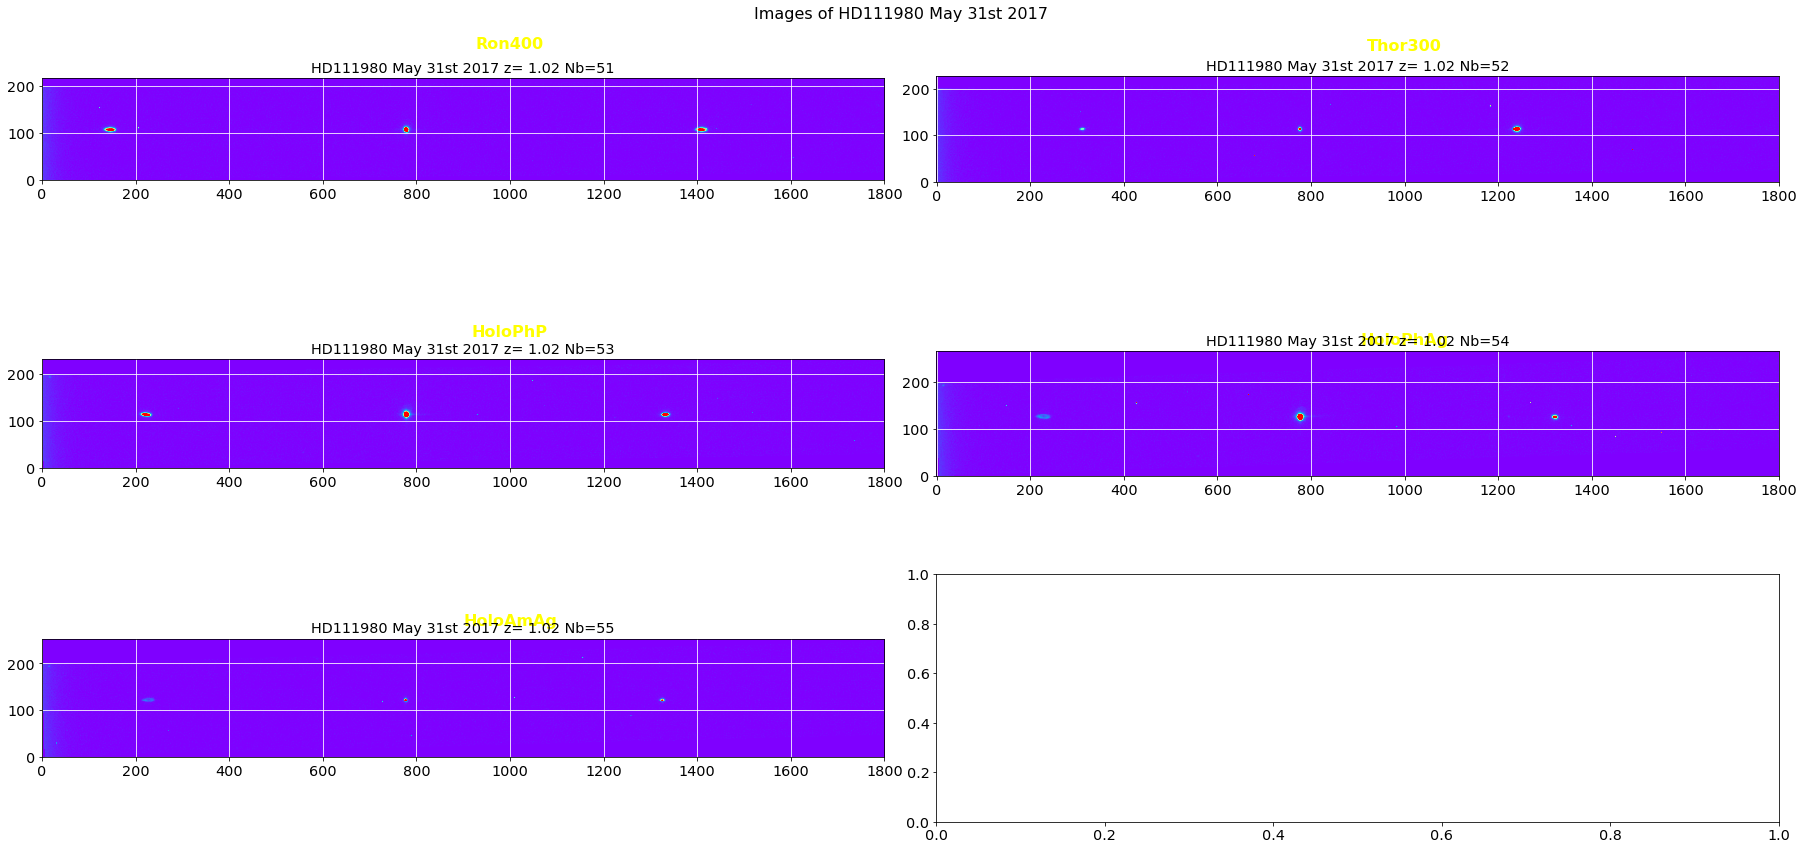

In [42]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images,all_filt)

In [43]:
print thex0
# le thorlabs 300 a un ordre +1 dominant
x0 = int(np.median(thex0))
thex0 = x0*np.ones_like(thex0)
print x0

[777, 1239, 777, 777, 776]
777


In [44]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os



def ShowOneOrder(all_images,all_titles,x0,object_name,all_expo,dir_top_images,figname):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        
        print index, 'exposition time = ',all_expo[index] 
        
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        
        if(all_expo[index]<=0 ): #special case of the first image
            reduc_image=full_image[90:150,1000:1800]  
        else:
            reduc_image=full_image[90:150,1000:1800]/all_expo[index] 
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    #plt.savefig(figfilename) 

0 exposition time =  60.0
1 exposition time =  20.0
2 exposition time =  60.0
3 exposition time =  60.0
4 exposition time =  60.0


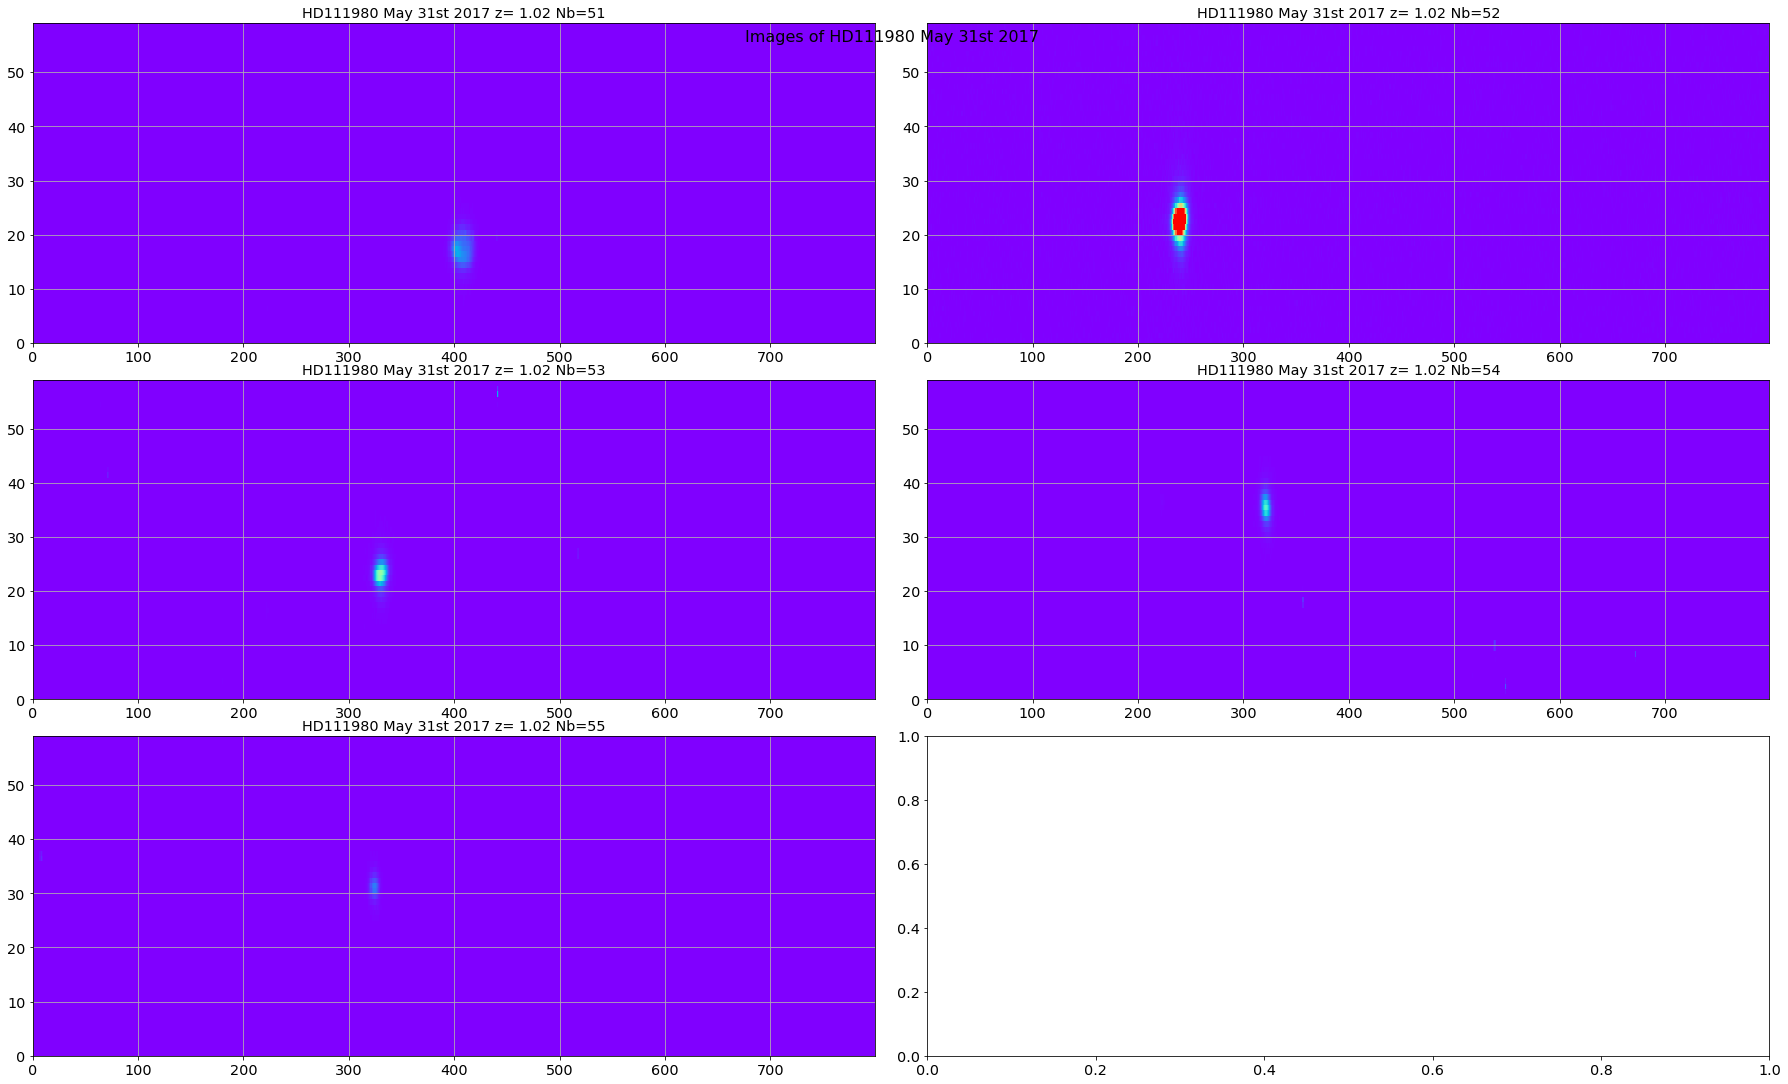

In [45]:
ShowOneOrder(all_images,all_titles,x0,object_name,all_expo,dir_top_images,'firstorderright.pdf')

### Shows the transverse profile

In [46]:
DeltaX=600
w=20
ws=70

In [47]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowTransverseProfile(all_images,x0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    The goal is to see in y, where is the spectrum maximum. Returns they0
    
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1

    ### Criteria for spectrum region selection
    DeltaX=1000
    w=10
    ws=80
    Dist=4*w
    right_edge = 1800
    
    thespectra= []
    thespectraUp=[]
    thespectraDown=[]
    
    they0 = []
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])[:,0:right_edge]

        
        #data[:,x0-100:x0+100]=0 ## TURN OFF CENTRAL STAR
        
        if(all_expo[index]<=0):            
            yprofile=np.sum(data,axis=1)
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
            
            
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #y0 = they0[index]
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        
        ##########################################################
        #### Here extract the spectrum around the central star
        #####   Take the sum un bins along y
        #############################################################
        
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)

        
        ### Lateral bands to remove sky background
        ### ---------------------------------------
        spectrum2DUp=np.copy(data[y0-w+Dist:y0+w+Dist,:])
        xprofileUp=np.median(spectrum2DUp,axis=0)*2.*float(w)

        spectrum2DDown=np.copy(data[y0-w-Dist:y0+w-Dist,:])
        xprofileDown=np.median(spectrum2DDown,axis=0)*2.*float(w)
        
        
        if(all_expo[index]<=0):
            thespectra.append(xprofile)
            thespectraUp.append(xprofileUp)
            thespectraDown.append(xprofileDown)
        else:  ################## HERE I NORMALISE WITH EXPO TIME ####################################
            thespectra.append(xprofile/all_expo[index])
            thespectraUp.append(xprofileUp/all_expo[index]) 
            thespectraDown.append(xprofileDown/all_expo[index]) 

        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    
    return thespectra,thespectraUp,thespectraDown,they0

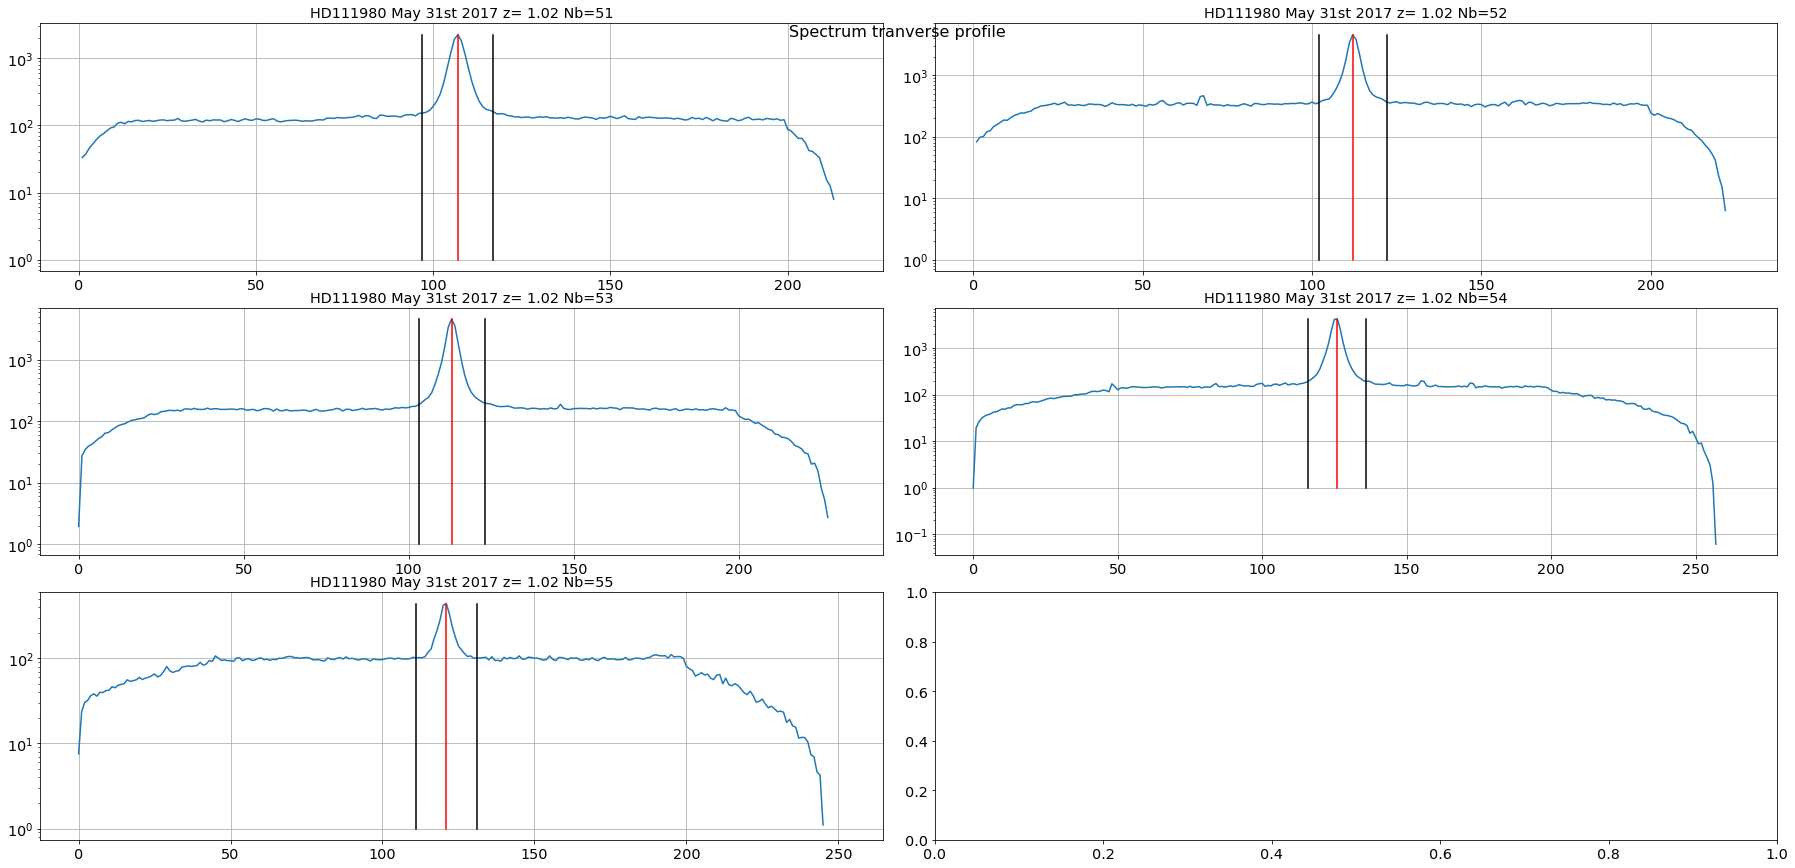

In [48]:
thespectra,thespectraUp,thespectraDown,they0=ShowTransverseProfile(all_images,x0,all_titles,object_name,all_expo,dir_top_images)

In [49]:
print they0

[107, 112, 113, 126, 121]


In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()
    
    right_edge = 1800
    
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])[:,0:right_edge]
        y_0=they0[index]
        x_0=thex0[index]

        reduc_image=full_image[y_0-20:y_0+20,x_0+100:right_edge]/all_expo[index]
        
        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=100)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Right part of spectrum of {} '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'rightorder.pdf')
    
    #plt.savefig(figfilename)  

In [51]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=2
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    #thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    f.tight_layout()

    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        full_image=np.copy(all_images[index])
        y_0=they0[index]
        x_0=thex0[index]
        
        
        reduc_image=full_image[y_0-20:y_0+20,0:x_0-100]/all_expo[index] 

        X,Y=np.meshgrid(np.arange(0,reduc_image.shape[1]),np.arange(reduc_image.shape[0]))
        im = axarr[iy,ix].pcolormesh(X,Y,reduc_image, cmap='rainbow',vmin=0,vmax=30)
        #axarr[iy,ix].colorbar(im, orientation='vertical')
        axarr[iy,ix].axis([X.min(), X.max(), Y.min(), Y.max()]); axarr[iy,ix].grid(True)
        
        axarr[iy,ix].set_title(all_titles[index])
        
    
    title='Left part of spectrum of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'leftorder.pdf')
    #plt.savefig(figfilename)  

### Right order

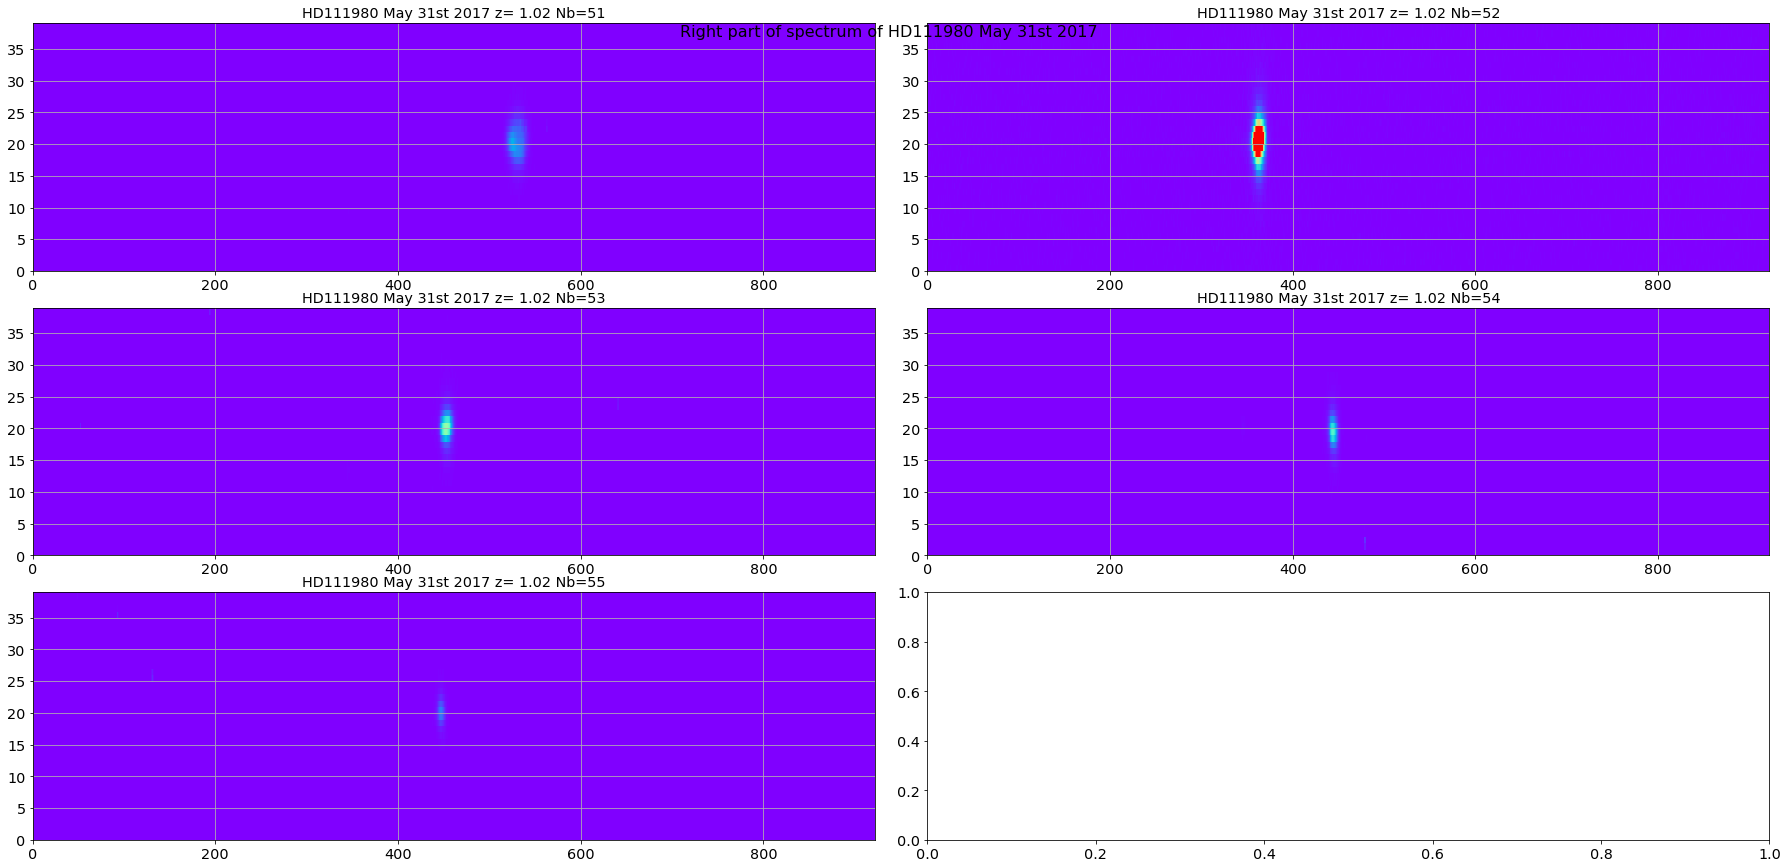

In [52]:
ShowRightOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

### Left order

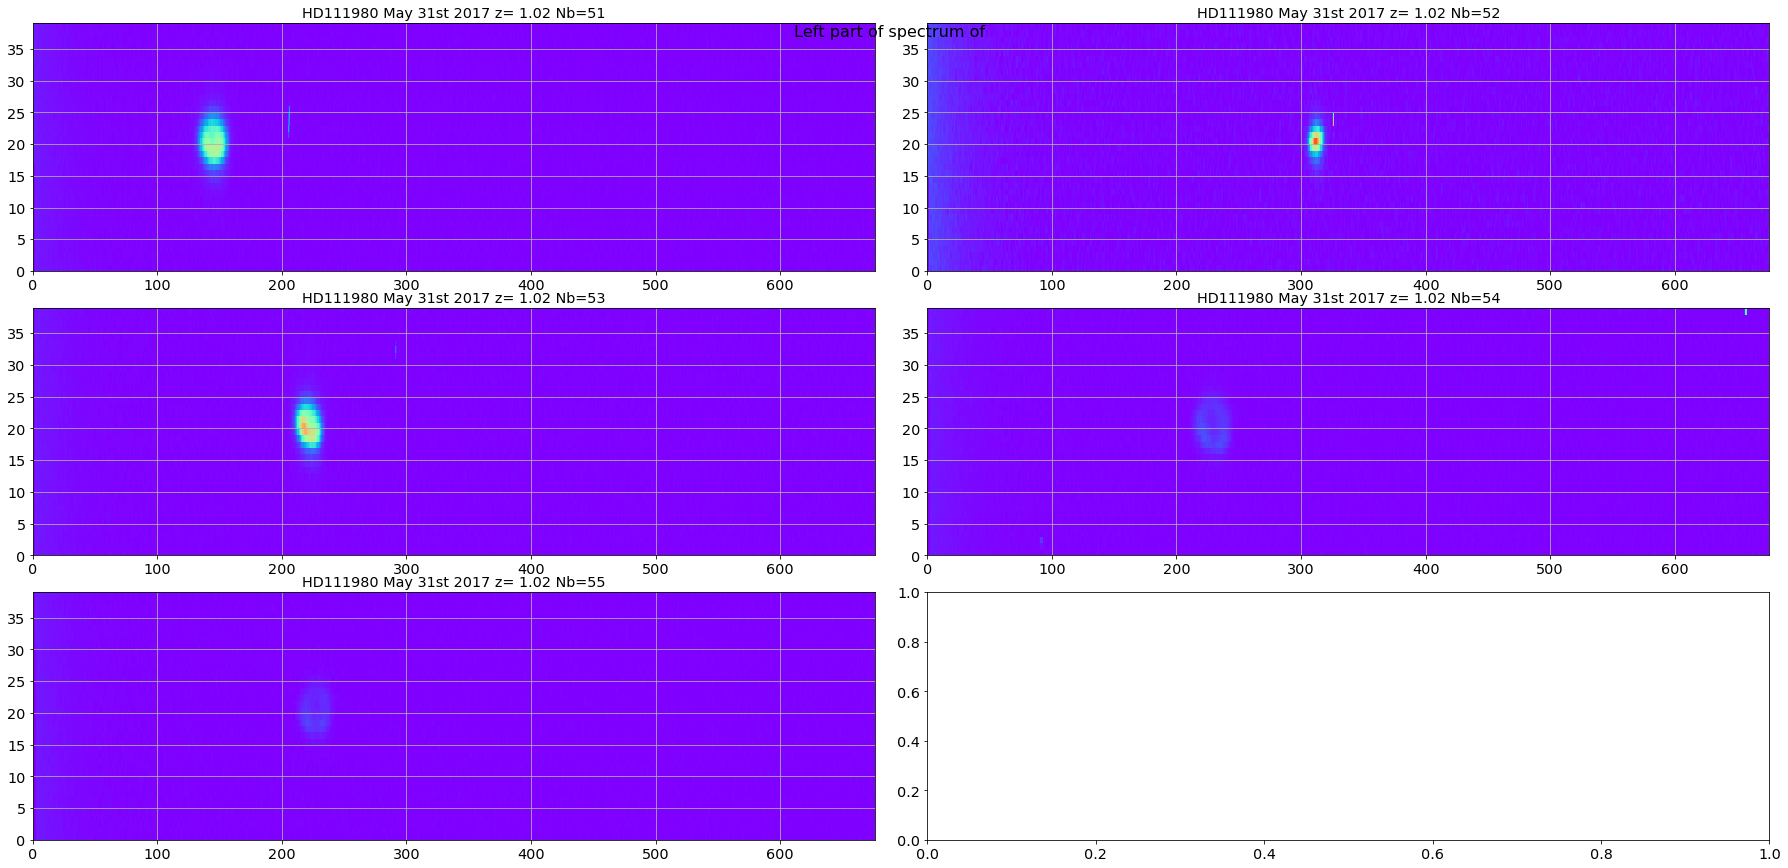

In [53]:
ShowLeftOrder(all_images,thex0,they0,all_titles,object_name,all_expo,dir_top_images)

In [54]:
def CleanBadPixels(spectraUp,spectraDown):
    
    Clean_Up= []
    Clean_Do = []
    Clean_Av = []
    eps=25.   # this is the minumum background Please check
    NBSPEC=len(spectraUp)
    for index in np.arange(0,NBSPEC):
        s_up=spectraUp[index]
        s_do=spectraDown[index]
    
        index_up=np.where(s_up<eps)
        index_do=np.where(s_do<eps)
        
        s_up[index_up]=s_do[index_up]
        s_do[index_do]=s_up[index_do]
        s_av=(s_up+s_do)/2.
        
        Clean_Up.append(s_up)
        Clean_Do.append(s_do)
        Clean_Av.append(s_av)
        
    return Clean_Up, Clean_Do,Clean_Av 

In [55]:
Clean_Up, Clean_Do,Clean_Av=CleanBadPixels(thespectraUp,thespectraDown) 

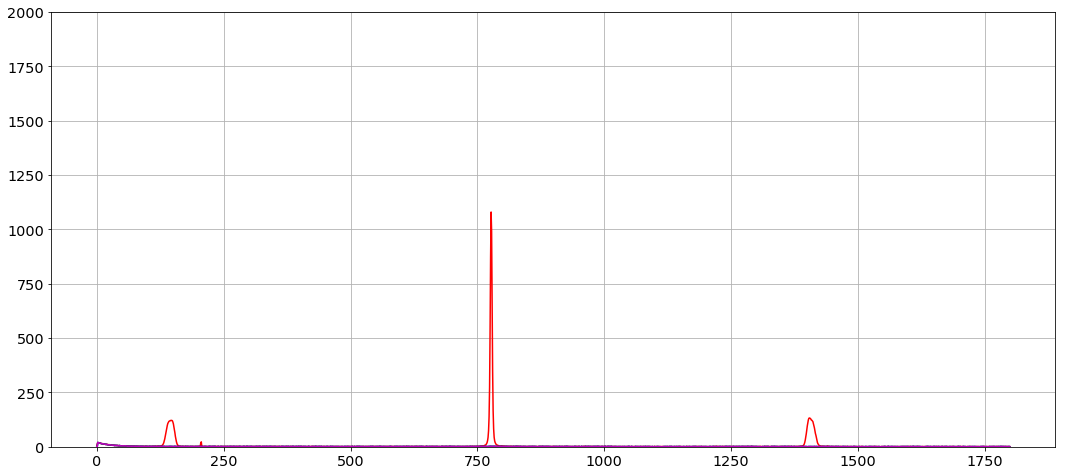

In [56]:
sel=0
plt.figure(figsize=(18,8))
plt.plot(thespectra[sel],'r-') 
plt.plot(Clean_Up[sel],'b-') 
plt.plot(Clean_Do[sel],'g-')
plt.plot(Clean_Av[sel],'m-')
plt.grid(True)
plt.ylim(0,2000.)
figfilename=os.path.join(dir_top_images,'bckg_sample.pdf')
plt.savefig(figfilename) 

In [57]:
def ShowLongitBackground(spectra,spectraUp,spectraDown,spectraAv,all_titles,object_name,dir_top_images):
    """
    Show the background to be removed to the spectrum
    """
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
   
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].plot(spectraUp[index],'b-')
        axarr[iy,ix].plot(spectraDown[index],'g-')
        axarr[iy,ix].plot(spectraAv[index],'m-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].text(1400.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    title='Longitudinal background Up/Down'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'background_longprofile.pdf')
    plt.savefig(figfilename)  
    

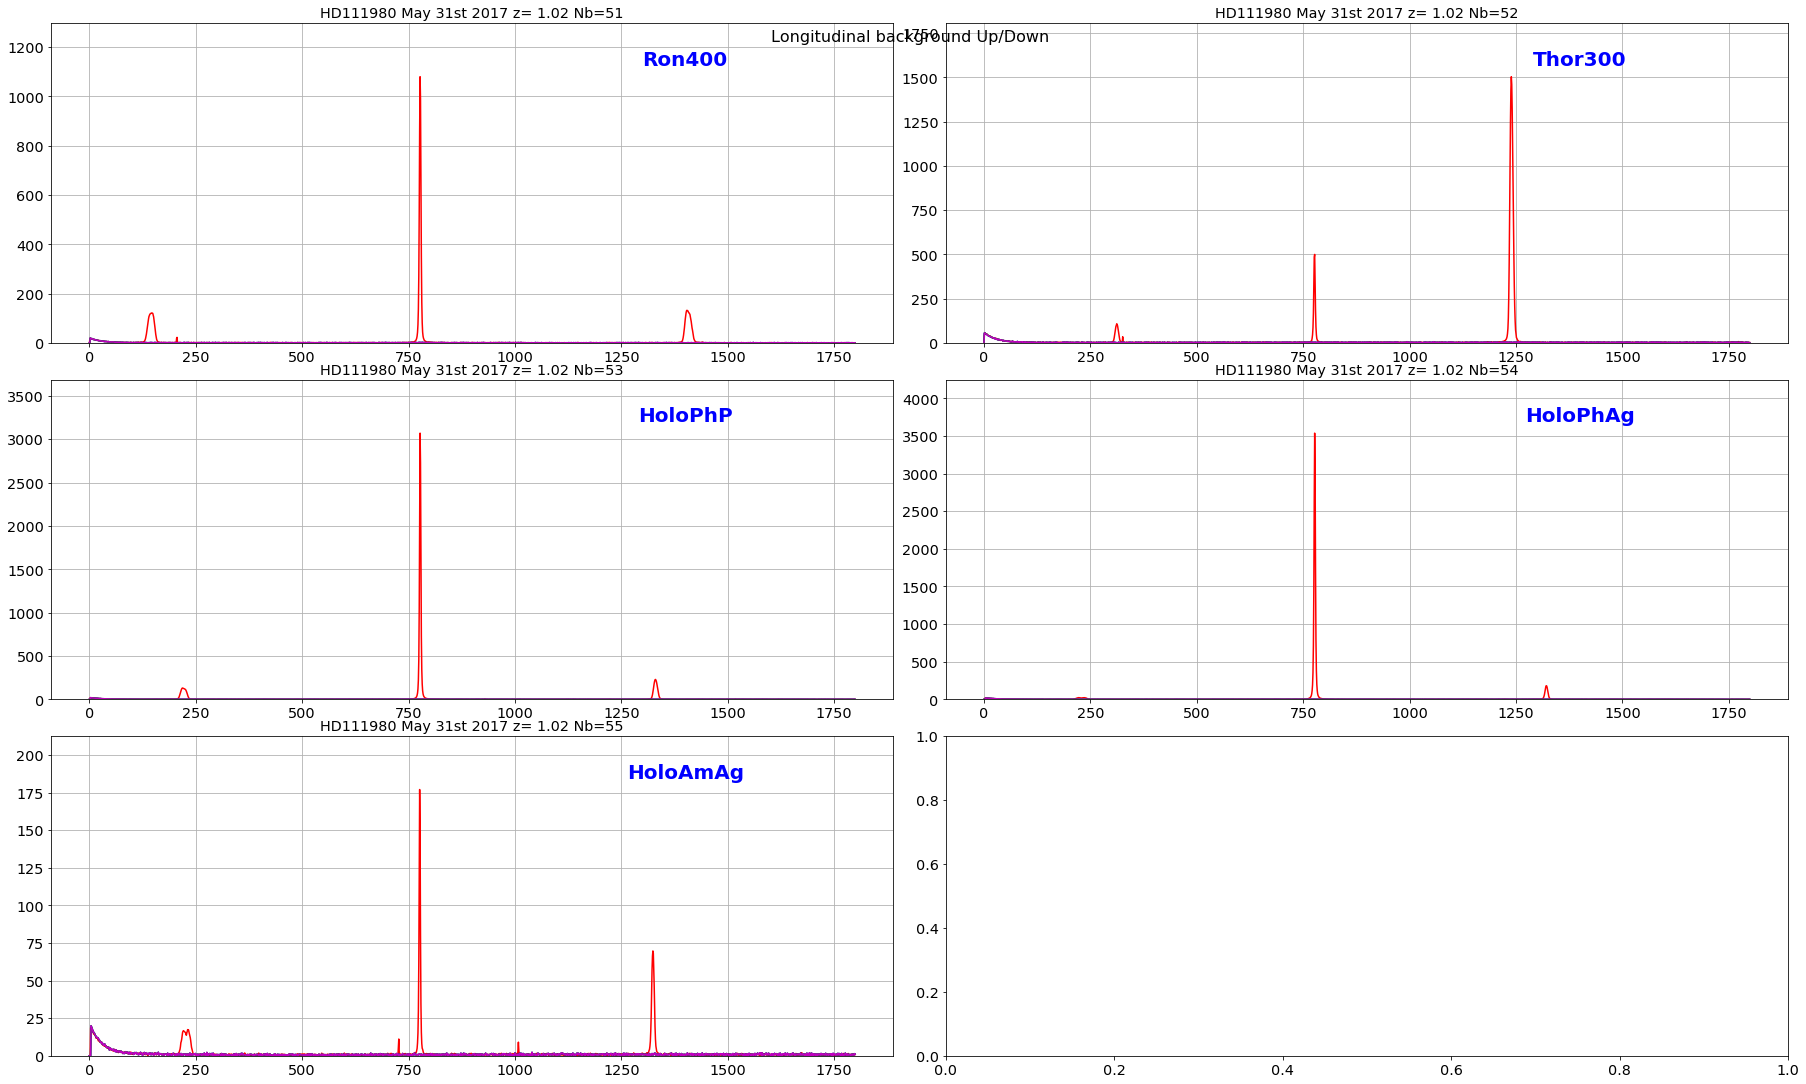

In [58]:
ShowLongitBackground(thespectra,Clean_Up,Clean_Do,Clean_Av,all_titles,object_name,dir_top_images)

In [59]:
def CorrectSpectrumFromBackground(spectra, background):
    """
    Background Subtraction
    """
    NBSPEC=len(spectra)
        
    corrected_spectra = []
    
    for index in np.arange(0,NBSPEC):
        corrspec=spectra[index]-background[index]
        corrected_spectra.append(corrspec)
    return corrected_spectra

In [60]:
thecorrspectra=CorrectSpectrumFromBackground(thespectra,Clean_Av)

In [61]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1800].max()*1.2)
        axarr[iy,ix].text(1000.,spectra[index][:1800].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile.pdf')
    plt.savefig(figfilename)  
    

#### Here below, we plot the latera (up and down ) background which has not been subtracted
For me the background remains flat and at zero


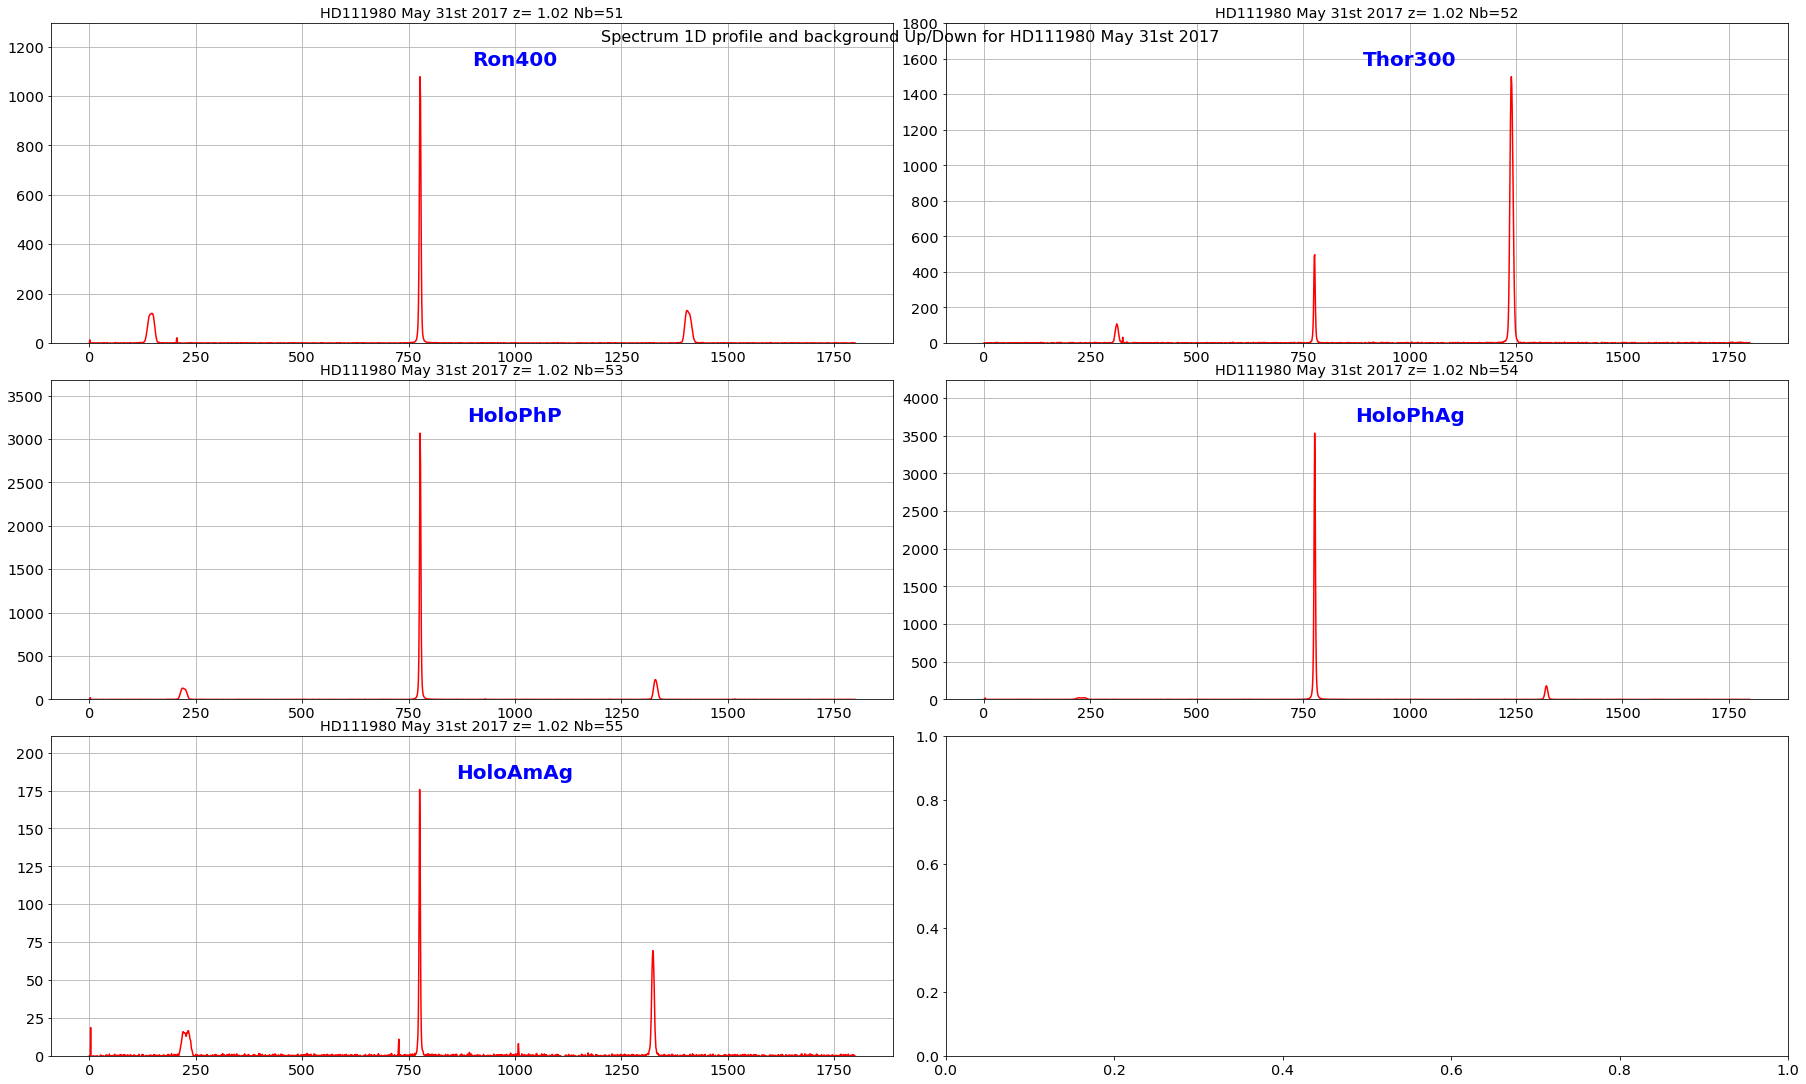

In [62]:
ShowSpectrumProfile(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

In [63]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def ShowSpectrumRightProfile2(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index],'r-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,spectra[index][:1900].max()*1.2)
        axarr[iy,ix].set_xlim(1000.,2000.)
        axarr[iy,ix].text(1400.,spectra[index][:1900].max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile2.pdf')
    plt.savefig(figfilename)  
    


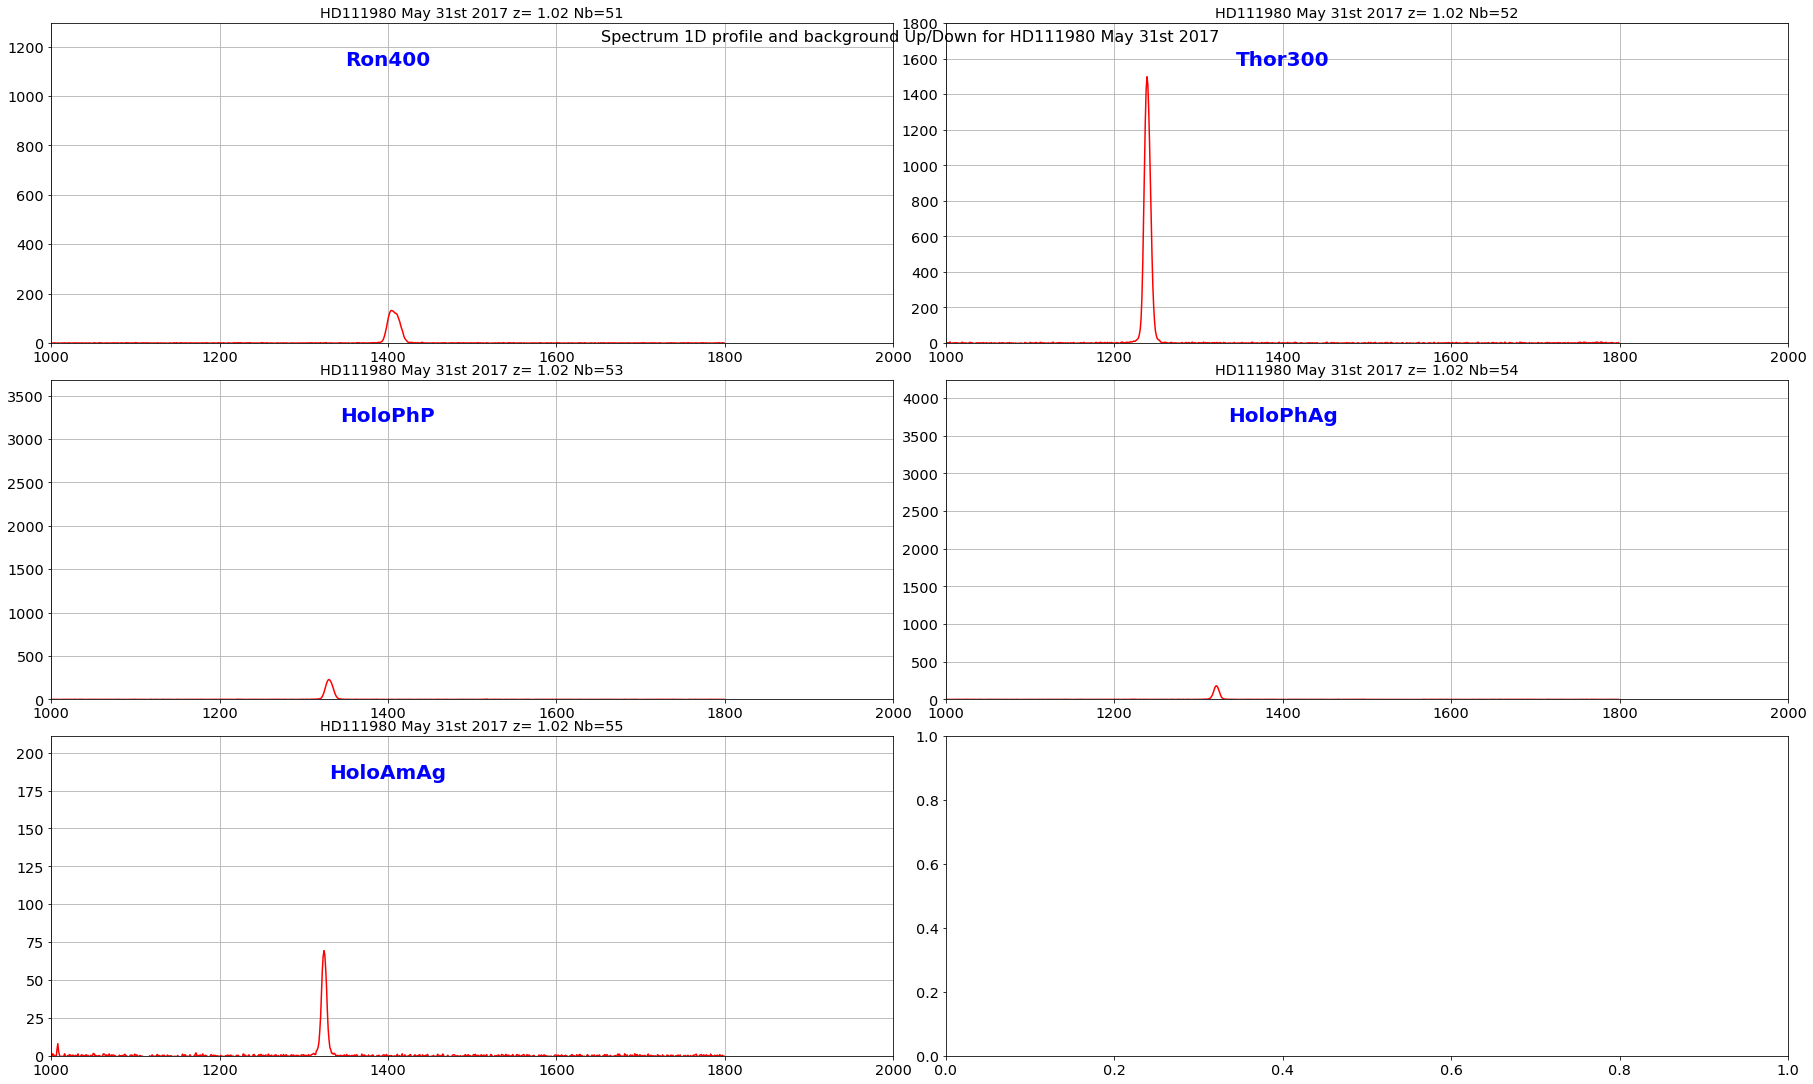

In [64]:
ShowSpectrumRightProfile2(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

## Ratio between amplitudes

In [65]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def SpectrumAmplitudeRatio(spectra):
    """
    SpectrumAmplitudeRatio: ratio of amplitudes
    =====================
    """
    ratio_list= []
    
    NBSPEC=len(spectra)
    
    for index in np.arange(0,NBSPEC):
       
        max_right=spectra[index][700:1900].max()
        max_left=spectra[index][:700].max()
        
        ratio=max_right/max_left
        ratio_list.append(ratio) 
        
    return ratio_list

In [66]:
ratio_of_maxamplitudes=SpectrumAmplitudeRatio(thecorrspectra)

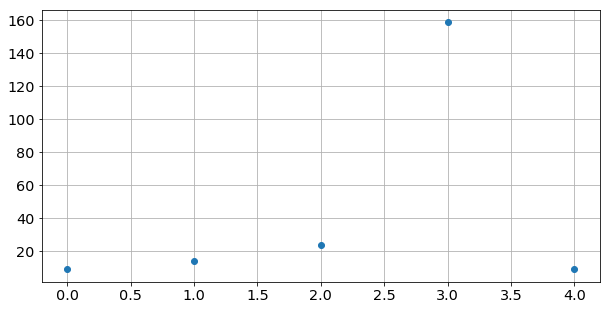

In [67]:
plt.figure(figsize=(10,5))
plt.plot(ratio_of_maxamplitudes,'o')
plt.grid()

In [68]:
print all_filt

['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']


## Example of a single spectrum

In [69]:
sel=0
spectrum_sel=thecorrspectra[sel]

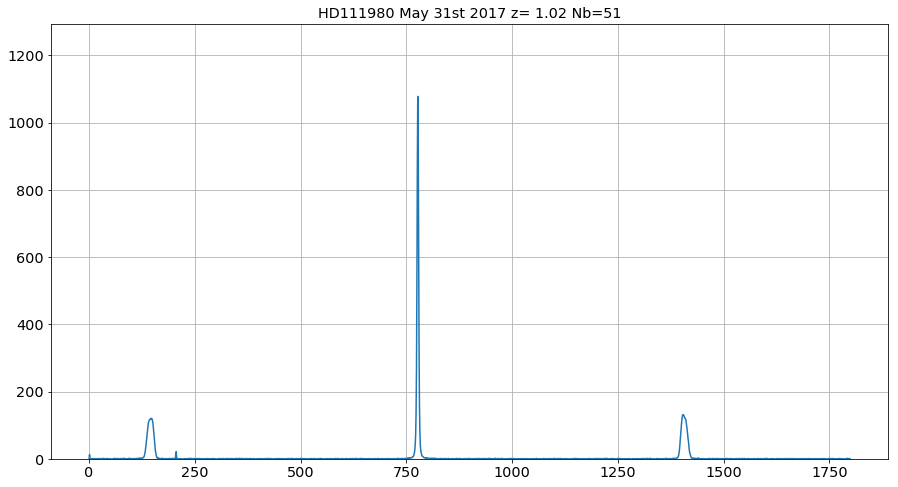

In [70]:
plt.figure(figsize=(15,8))
plt.plot(spectrum_sel)
title=all_titles[sel]
plt.title(title)
plt.grid(True)
plt.ylim(0,spectrum_sel[:1900].max()*1.2)
figfilename=os.path.join(dir_top_images,'singlespec_sample.pdf')
plt.savefig(figfilename) 

# Grating characterisation

Ajuster les paramètres ici pour supprimes les lignes blanches, étoiles proches, etc... et les propager dans la fonction FWHMProfiles

In [95]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit_gauss(x,y,guess=[10,1000,1],bounds=(-np.inf,np.inf)):
    popt,pcov = curve_fit(gauss,x,y,p0=guess,bounds=bounds)
    return popt, pcov

def EmissionLineFit(spectra,left_edge=1200,right_edge=1600,guess=[10,1400,200],bounds=(-np.inf,np.inf)):
    xs = np.arange(left_edge,right_edge,1)
    right_spectrum = spectra[left_edge:right_edge]
    popt, pcov = fit_gauss(xs,right_spectrum,guess=guess)
    return(popt, pcov)
    

def ShowRightSpectrumProfileFit(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowRightSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    left_edge = 1200
    right_edge = 1600
    xs = np.arange(left_edge,right_edge,1)
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        popt, pcov = EmissionLineFit(spectra[index],left_edge,right_edge,guess=[10,1400,200])
        
        right_spectrum = spectra[index][left_edge:right_edge]
        axarr[iy,ix].plot(xs,right_spectrum,'r-',lw=2)
        axarr[iy,ix].plot(xs,gauss(xs,*popt),'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,right_spectrum.max()*1.2)
        axarr[iy,ix].set_xlim(left_edge,right_edge)
        axarr[iy,ix].text(1400.,right_spectrum.max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile2.pdf')
    plt.savefig(figfilename)  
    

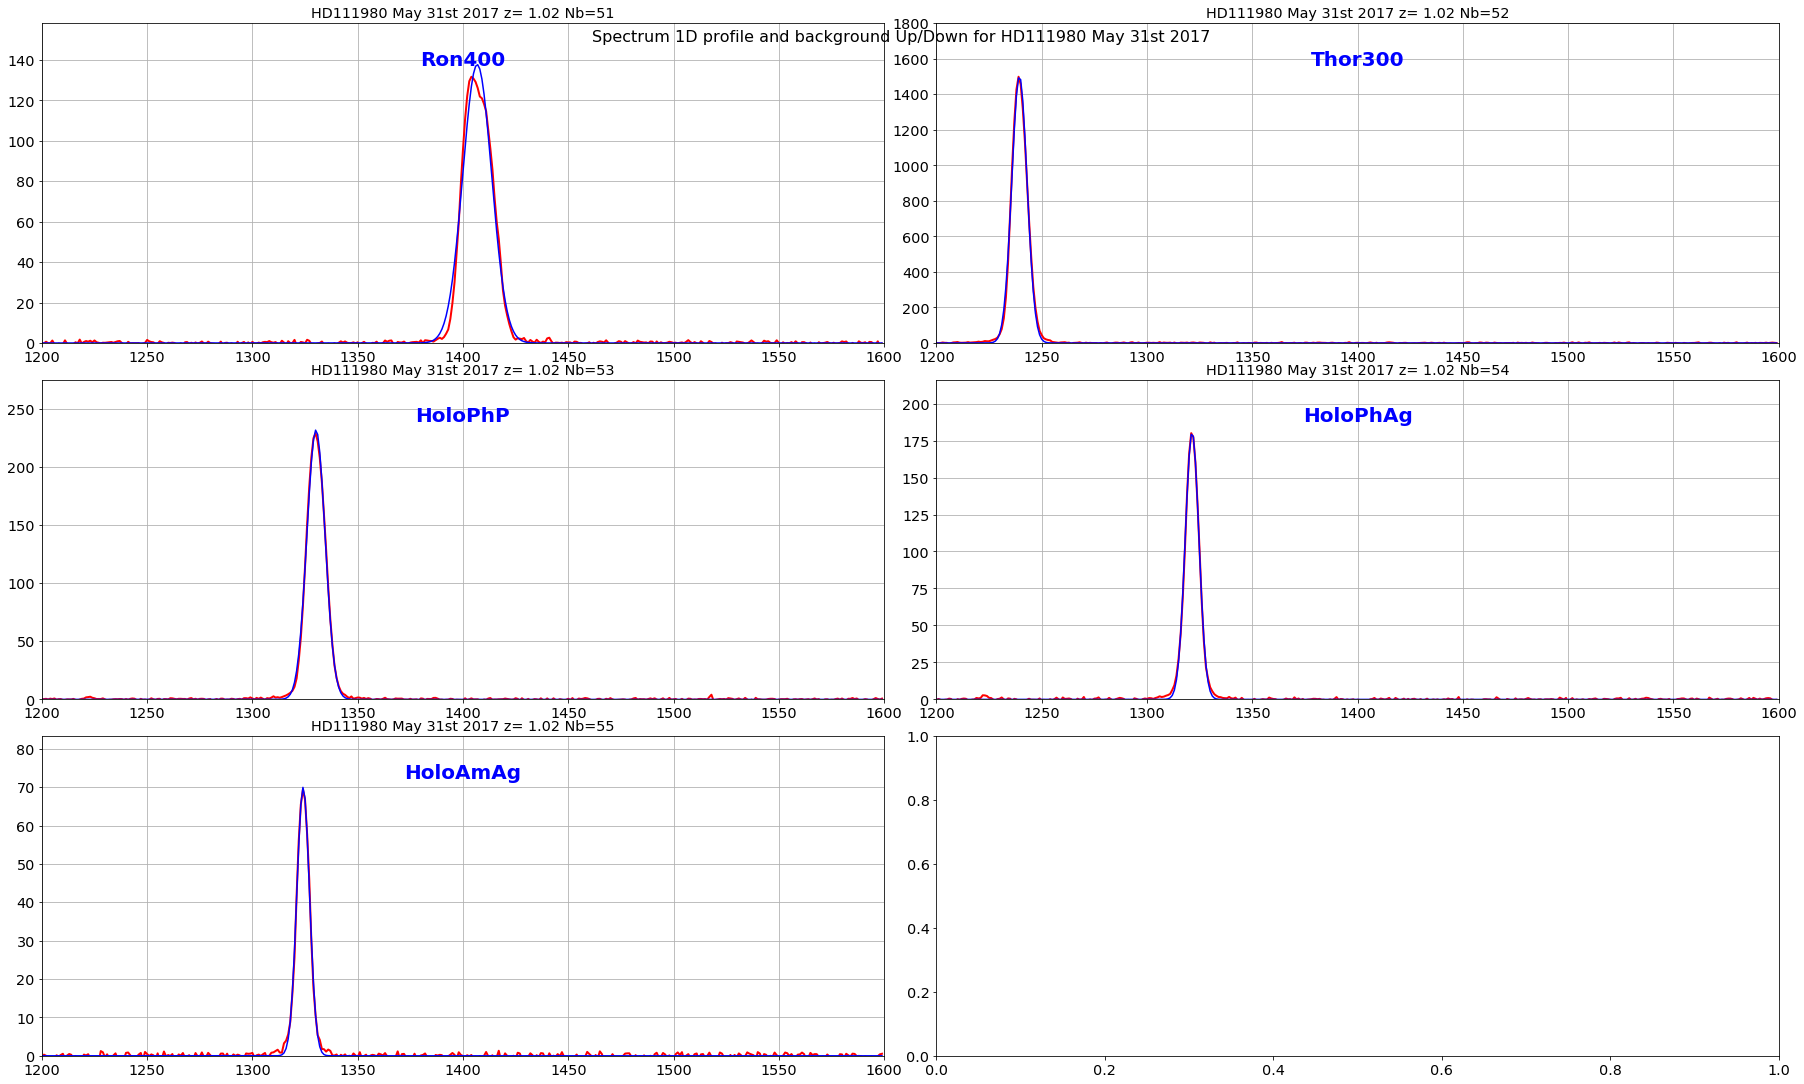

In [96]:
ShowRightSpectrumProfileFit(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

In [73]:
def ShowLeftSpectrumProfileFit(spectra,all_titles,object_name,dir_top_images,all_filt):
    """
    ShowLeftSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=2
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    #MaxY= [150.,150.,150.,5000.,1500.,1000.,5000.,5000.,500.,150.]
    
    left_edge = 100
    right_edge = 400
    xs = np.arange(left_edge,right_edge,1)
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,5*MAXIMGROW))
    f.tight_layout()
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        popt, pcov = EmissionLineFit(spectra[index],left_edge,right_edge,guess=[10,200,100],bounds=((50,300),(left_edge,right_edge),(0,30)))
        
        right_spectrum = spectra[index][left_edge:right_edge]
        axarr[iy,ix].plot(xs,right_spectrum,'r-',lw=2)
        axarr[iy,ix].plot(xs,gauss(xs,*popt),'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,right_spectrum.max()*1.2)
        axarr[iy,ix].set_xlim(left_edge,right_edge)
        axarr[iy,ix].text(300.,right_spectrum.max()*1.1, all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
    
    title='Spectrum 1D profile and background Up/Down for {}'.format(object_name)
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'correctedspectrum_profile2.pdf')
    plt.savefig(figfilename)  


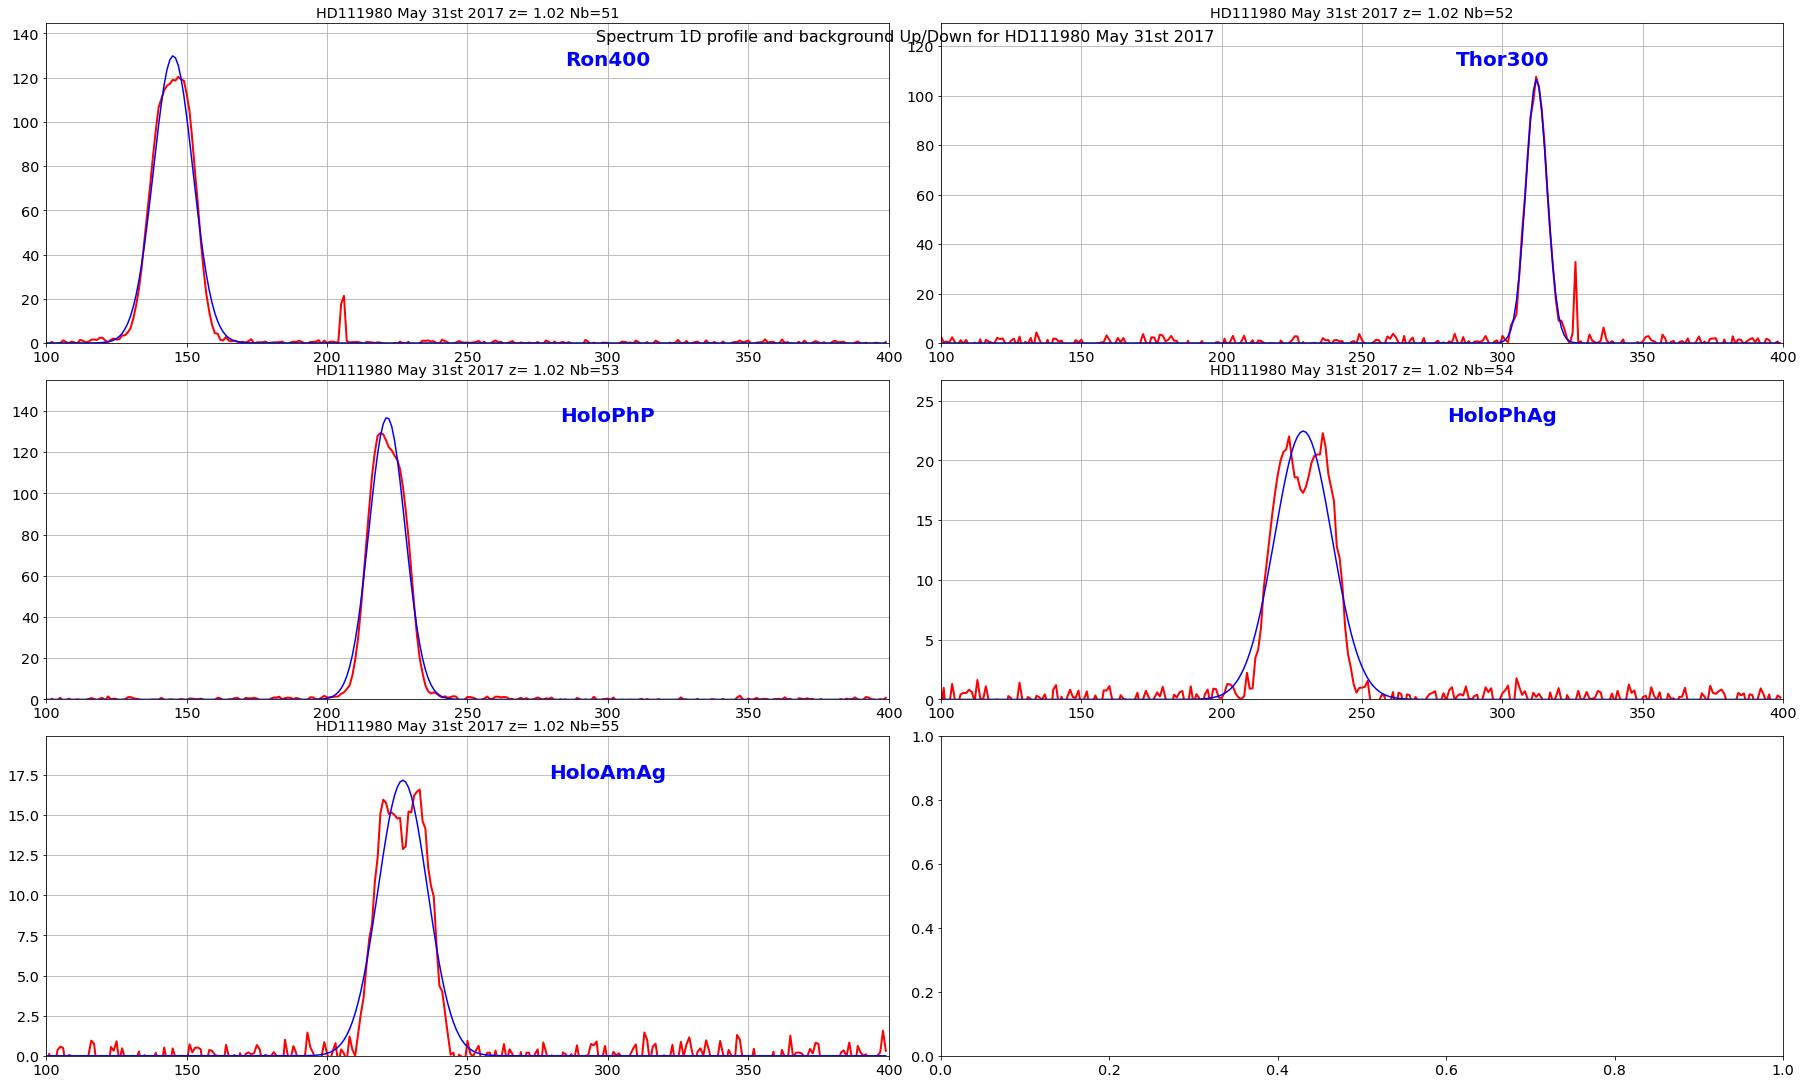

In [74]:
ShowLeftSpectrumProfileFit(thecorrspectra,all_titles,object_name,dir_top_images,all_filt)

### Distance to CCD estimation using Ron400 and Thor300

In [156]:
%autoreload 2
from holo_specs import *

def CalibrateDistance2CCD_OneOrder(thecorrspectra,thex0,all_filt,left_edge=1200,right_edge=1600,guess=[10,1400,200],bounds=(-np.inf,np.inf)):

    f, axarr = plt.subplots(2,2,figsize=(25,10))
    count = 0
    D_range = 1 # in mm
    print 'Present distance to CCD : %.2f mm (to update if necessary)' % DISTANCE2CCD
    print '-------------------------------'    
    distances = []
    distances_err = []
    for index in range(len(thecorrspectra)):
        if all_filt[index] != "Ron400" and all_filt[index] != "Thor300" : continue
        if all_filt[index] == "Thor300" : N_theo = 300
        if all_filt[index] == "Ron400"  : N_theo = 400  
        # dispersion axis analysis
        spectra = thecorrspectra[index]
        popt, pcov = EmissionLineFit(spectra,left_edge,right_edge,guess,bounds)
        x0 = popt[1]
        x0_err = np.sqrt(pcov[1][1]) 
        deltaX = np.abs(x0 - thex0[index])
        theta0 = (thex0[index] - IMSIZE/2)*PIXEL2ARCSEC*ARCSEC2RADIANS
        deltaX0 = np.tan(theta0)*DISTANCE2CCD/PIXEL2MM
        print theta0,deltaX0
        print all_filt[index]
        print 'Position of the H-alpha emission line : %.2f +/- %.2f pixels (%.2f percent)' % (deltaX,x0_err,x0_err/deltaX*100)
        Ds = np.linspace(DISTANCE2CCD-D_range,DISTANCE2CCD+D_range,100)
        Ns = []
        diffs = []
        optimal_D = DISTANCE2CCD
        optimal_D_inf = DISTANCE2CCD
        optimal_D_sup = DISTANCE2CCD
        test = 1e20
        test_sup = 1e20
        test_inf = 1e20
        for D in Ds :
            theta = np.arctan2(deltaX*PIXEL2MM,D)
            N = np.sin(theta)/(HALPHA_CENTER)
            Ns.append( N )
            diff = np.abs(N-N_theo)
            diff_sup = np.abs(N-N_theo+1)
            diff_inf = np.abs(N-N_theo-1)
            diffs.append(diff)
            if diff < test :
                test = diff
                optimal_D = D
            if diff_sup < test_sup :
                test_sup = diff_sup
                optimal_D_sup = D
            if diff_inf < test_inf :
                test_inf = diff_inf
                optimal_D_inf = D
        optimal_D_err  = 0.5*(optimal_D_sup-optimal_D_inf)
        distances.append(optimal_D)
        distances_err.append(optimal_D_err)
        print 'Deduced distance to CCD with %s : %.2f +/- %.2f mm (%.2f percent)' % (all_filt[index],optimal_D,optimal_D_err,100*optimal_D_err/optimal_D)
        # plot Ns vs Ds
        axarr[0,count].plot(Ds,Ns,'b-',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo,N_theo],'r-',lw=2)
        axarr[0,count].plot([optimal_D,optimal_D],[np.min(Ns),np.max(Ns)],'r-',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo+1,N_theo+1],'k--',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],'k--',lw=2)
        axarr[0,count].plot([optimal_D_inf,optimal_D_inf],[np.min(Ns),np.max(Ns)],'k--',lw=2)
        axarr[0,count].plot([optimal_D_sup,optimal_D_sup],[np.min(Ns),np.max(Ns)],'k--',lw=2)
        axarr[0,count].fill_between([optimal_D_inf,optimal_D_sup],[np.min(Ns),np.min(Ns)],[np.max(Ns),np.max(Ns)],color='red',alpha=0.2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],'k--',lw=2)
        axarr[0,count].fill_between([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],[N_theo+1,N_theo+1],color='red',alpha=0.2)
        axarr[0,count].scatter([optimal_D],[N_theo],s=200,color='r')
        axarr[0,count].set_xlim([np.min(Ds),np.max(Ds)])
        axarr[0,count].set_ylim([np.min(Ns),np.max(Ns)])
        axarr[0,count].grid(True)
        axarr[0,count].text(DISTANCE2CCD+0.6*D_range,N_theo+2.3,all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
        axarr[0,count].set_xlabel('Distance to CCD [mm]',fontsize=16)
        axarr[0,count].set_ylabel('Grooves per mm',fontsize=16)
        # plot diffs vs Ds
        axarr[1,count].plot(Ds,diffs,'b-',lw=2)
        axarr[1,count].plot([optimal_D,optimal_D],[np.min(diffs),np.max(diffs)],'r-',lw=2)
        axarr[1,count].plot([np.min(Ds),np.max(Ds)],[1,1],'k--',lw=2)
        #axarr[1,count].scatter([N_theo],[optimal_D],s=200,color='r')
        axarr[1,count].set_xlim([np.min(Ds),np.max(Ds)])
        axarr[1,count].set_ylim([np.min(diffs),np.max(diffs)])
        axarr[1,count].grid(True)
        axarr[1,count].set_xlabel('Distance to CCD [mm]',fontsize=16)
        axarr[1,count].set_ylabel('Difference to $N_{\mathrm{theo}}$ [grooves per mm]',fontsize=16)
        axarr[1,count].plot([optimal_D_inf,optimal_D_inf],[np.min(diffs),np.max(diffs)],'k--',lw=2)
        axarr[1,count].plot([optimal_D_sup,optimal_D_sup],[np.min(diffs),np.max(diffs)],'k--',lw=2)
        axarr[1,count].fill_between([optimal_D_inf,optimal_D_sup],[np.min(diffs),np.min(diffs)],[np.max(diffs),np.max(diffs)],color='red',alpha=0.2)
        axarr[1,count].text(DISTANCE2CCD+0.6*D_range,2.5,all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
        count += 1
        print '-------------------------------'  
    distances_mean = np.mean(distances)
    distances_mean_err = np.sqrt(np.mean(np.array(distances_err)**2))
    print 'Average distance to CCD : %.2f +/- %.2f mm (%.2f percent)' % (distances_mean,distances_mean_err,100*distances_mean_err/distances_mean)

    plt.show()
    return(distances_mean,distances_mean_err)

Present distance to CCD : 55.56 mm (to update if necessary)
-------------------------------
-0.000480193406729 -1.11164782202
Ron400
Position of the H-alpha emission line : 629.76 +/- 0.05 pixels (0.01 percent)
Deduced distance to CCD with Ron400 : 55.59 +/- 0.14 mm (0.25 percent)
-------------------------------
-0.000480193406729 -1.11164782202
Thor300
Position of the H-alpha emission line : 462.41 +/- 0.01 pixels (0.00 percent)
Deduced distance to CCD with Thor300 : 55.31 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.45 +/- 0.17 mm (0.30 percent)


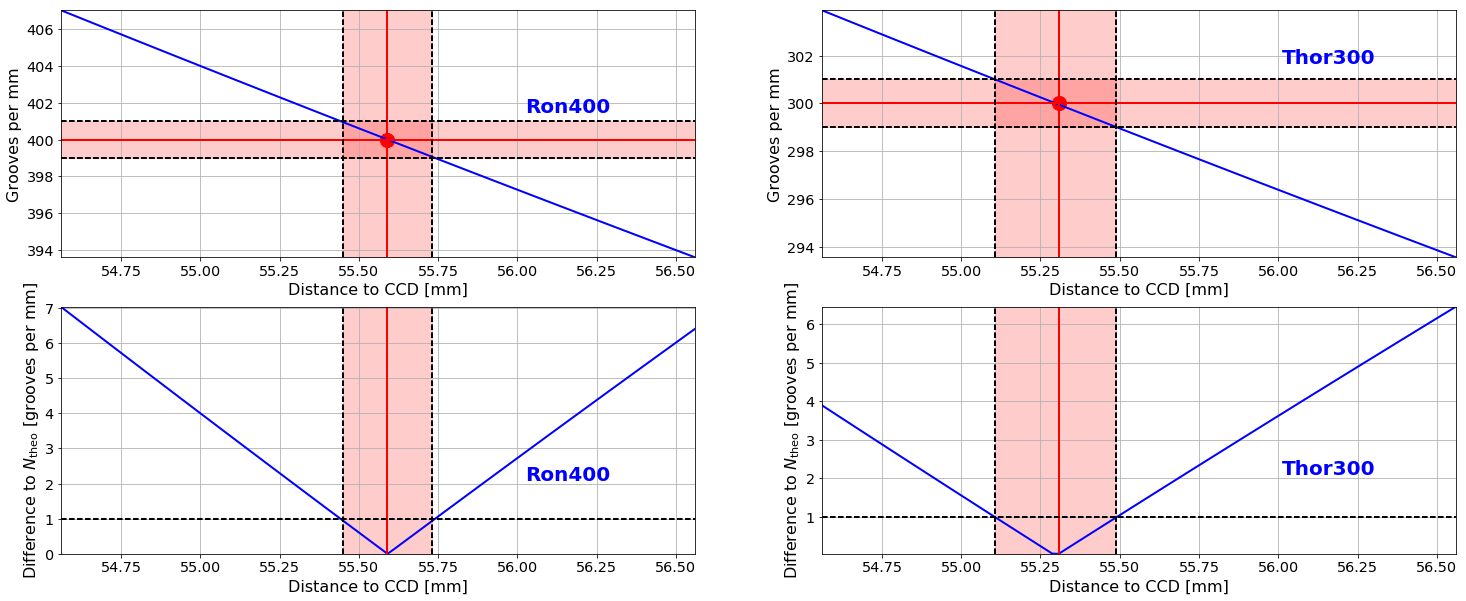

Present distance to CCD : 55.56 mm (to update if necessary)
-------------------------------
-0.000480193406729 -1.11164782202
Ron400
Position of the H-alpha emission line : 631.83 +/- 0.07 pixels (0.01 percent)
Deduced distance to CCD with Ron400 : 55.77 +/- 0.14 mm (0.25 percent)
-------------------------------
-0.000480193406729 -1.11164782202
Thor300
Position of the H-alpha emission line : 464.89 +/- 0.05 pixels (0.01 percent)
Deduced distance to CCD with Thor300 : 55.59 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.68 +/- 0.17 mm (0.30 percent)


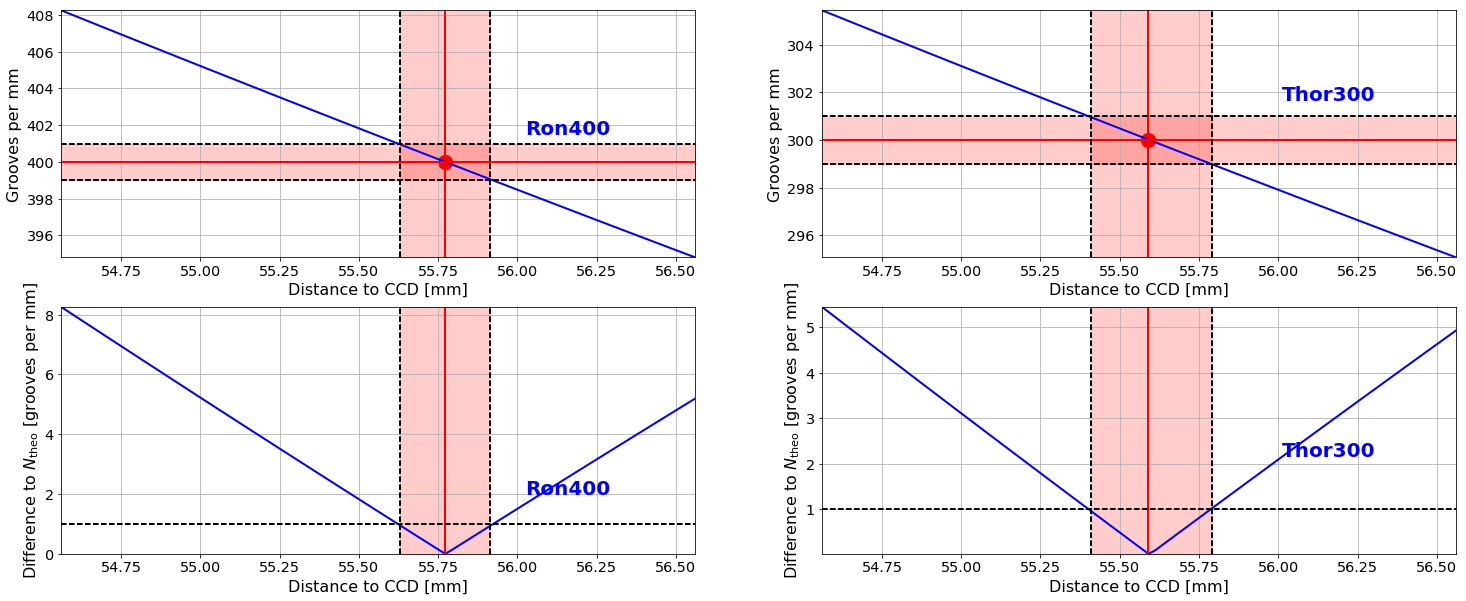

-------------------------------
Average distance to CCD : 55.57 +/- 0.17 mm (0.30 percent)


In [157]:
left_edge = 1200
right_edge = 1600
guess = [10,1400,200]
distance_rightorder, distance_rightorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,thex0,all_filt,left_edge,right_edge,guess)

left_edge = 100
right_edge = 400
guess=[10,200,100]
distance_leftorder, distance_leftorder_err = CalibrateDistance2CCD_OneOrder(thecorrspectra,thex0,all_filt,left_edge,right_edge,guess)

print '-------------------------------'  
distance_mean = np.mean([distance_rightorder,distance_leftorder])
distance_mean_err = np.sqrt(np.mean(np.array([distance_rightorder_err,distance_leftorder_err])**2))
print 'Average distance to CCD : %.2f +/- %.2f mm (%.2f percent)' % (distance_mean,distance_mean_err,100*distance_mean_err/distance_mean)

In [77]:
%autoreload 2
from holo_specs import *

def CalibrateDistance2CCD_TwoOrder(thecorrspectra,all_filt,leftorder_edges=[100,400],rightorder_edges=[1200,1600],guess=[[10,200,100],[10,1400,200]],bounds=(-np.inf,np.inf)):

    f, axarr = plt.subplots(2,2,figsize=(25,10))
    count = 0
    D_range = 1 # in mm
    print 'Present distance to CCD : %.2f mm (to update if necessary)' % DISTANCE2CCD
    print '-------------------------------'    
    distances = []
    distances_err = []
    for index in range(len(thecorrspectra)):
        if all_filt[index] != "Ron400" and all_filt[index] != "Thor300" : continue
        if all_filt[index] == "Thor300" : N_theo = 300
        if all_filt[index] == "Ron400"  : N_theo = 400  
        # dispersion axis analysis
        spectra = thecorrspectra[index]
        popt, pcov = EmissionLineFit(spectra,leftorder_edges[0],leftorder_edges[1],guess[0],bounds)
        x0_left = popt[1]
        x0_left_err = np.sqrt(pcov[1][1]) 
        popt, pcov = EmissionLineFit(spectra,rightorder_edges[0],rightorder_edges[1],guess[1],bounds)
        x0_right = popt[1]
        x0_right_err = np.sqrt(pcov[1][1]) 
        deltaX = 0.5*np.abs(x0_right - x0_left)
        x0_err = 0.5*np.sqrt(x0_right_err**2+x0_left_err**2)
        print all_filt[index], x0_left, x0_right
        print 'Position of the H-alpha emission line : %.2f +/- %.2f pixels (%.2f percent)' % (deltaX,x0_err,x0_err/deltaX*100)
        Ds = np.linspace(DISTANCE2CCD-D_range,DISTANCE2CCD+D_range,100)
        Ns = []
        diffs = []
        optimal_D = DISTANCE2CCD
        optimal_D_inf = DISTANCE2CCD
        optimal_D_sup = DISTANCE2CCD
        test = 1e20
        test_sup = 1e20
        test_inf = 1e20
        for D in Ds :
            theta = np.arctan2(deltaX*PIXEL2MM,D)
            N = np.sin(theta)/HALPHA_CENTER
            Ns.append( N )
            diff = np.abs(N-N_theo)
            diff_sup = np.abs(N-N_theo+1)
            diff_inf = np.abs(N-N_theo-1)
            diffs.append(diff)
            if diff < test :
                test = diff
                optimal_D = D
            if diff_sup < test_sup :
                test_sup = diff_sup
                optimal_D_sup = D
            if diff_inf < test_inf :
                test_inf = diff_inf
                optimal_D_inf = D
        optimal_D_err  = 0.5*(optimal_D_sup-optimal_D_inf)
        distances.append(optimal_D)
        distances_err.append(optimal_D_err)
        print 'Deduced distance to CCD with %s : %.2f +/- %.2f mm (%.2f percent)' % (all_filt[index],optimal_D,optimal_D_err,100*optimal_D_err/optimal_D)
        # plot Ns vs Ds
        axarr[0,count].plot(Ds,Ns,'b-',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo,N_theo],'r-',lw=2)
        axarr[0,count].plot([optimal_D,optimal_D],[np.min(Ns),np.max(Ns)],'r-',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo+1,N_theo+1],'k--',lw=2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],'k--',lw=2)
        axarr[0,count].plot([optimal_D_inf,optimal_D_inf],[np.min(Ns),np.max(Ns)],'k--',lw=2)
        axarr[0,count].plot([optimal_D_sup,optimal_D_sup],[np.min(Ns),np.max(Ns)],'k--',lw=2)
        axarr[0,count].fill_between([optimal_D_inf,optimal_D_sup],[np.min(Ns),np.min(Ns)],[np.max(Ns),np.max(Ns)],color='red',alpha=0.2)
        axarr[0,count].plot([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],'k--',lw=2)
        axarr[0,count].fill_between([np.min(Ds),np.max(Ds)],[N_theo-1,N_theo-1],[N_theo+1,N_theo+1],color='red',alpha=0.2)
        axarr[0,count].scatter([optimal_D],[N_theo],s=200,color='r')
        axarr[0,count].set_xlim([np.min(Ds),np.max(Ds)])
        axarr[0,count].set_ylim([np.min(Ns),np.max(Ns)])
        axarr[0,count].grid(True)
        axarr[0,count].text(DISTANCE2CCD+0.6*D_range,N_theo+2.3,all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
        axarr[0,count].set_xlabel('Distance to CCD [mm]',fontsize=16)
        axarr[0,count].set_ylabel('Grooves per mm',fontsize=16)
        # plot diffs vs Ds
        axarr[1,count].plot(Ds,diffs,'b-',lw=2)
        axarr[1,count].plot([optimal_D,optimal_D],[np.min(diffs),np.max(diffs)],'r-',lw=2)
        axarr[1,count].plot([np.min(Ds),np.max(Ds)],[1,1],'k--',lw=2)
        #axarr[1,count].scatter([N_theo],[optimal_D],s=200,color='r')
        axarr[1,count].set_xlim([np.min(Ds),np.max(Ds)])
        axarr[1,count].set_ylim([np.min(diffs),np.max(diffs)])
        axarr[1,count].grid(True)
        axarr[1,count].set_xlabel('Distance to CCD [mm]',fontsize=16)
        axarr[1,count].set_ylabel('Difference to $N_{\mathrm{theo}}$ [grooves per mm]',fontsize=16)
        axarr[1,count].plot([optimal_D_inf,optimal_D_inf],[np.min(diffs),np.max(diffs)],'k--',lw=2)
        axarr[1,count].plot([optimal_D_sup,optimal_D_sup],[np.min(diffs),np.max(diffs)],'k--',lw=2)
        axarr[1,count].fill_between([optimal_D_inf,optimal_D_sup],[np.min(diffs),np.min(diffs)],[np.max(diffs),np.max(diffs)],color='red',alpha=0.2)
        axarr[1,count].text(DISTANCE2CCD+0.6*D_range,2,all_filt[index],verticalalignment='top', horizontalalignment='center',color='blue',fontweight='bold', fontsize=20)
        count += 1
        print '-------------------------------'  
    distances_mean = np.mean(distances)
    distances_mean_err = np.sqrt(np.mean(np.array(distances_err)**2))
    print 'Average distance to CCD : %.2f +/- %.2f mm (%.2f percent)' % (distances_mean,distances_mean_err,100*distances_mean_err/distances_mean)

    plt.show()
    return(distances_mean,distances_mean_err)

Present distance to CCD : 55.56 mm (to update if necessary)
-------------------------------
Ron400 145.174905629 1406.76148873
Position of the H-alpha emission line : 630.79 +/- 0.04 pixels (0.01 percent)
Deduced distance to CCD with Ron400 : 55.69 +/- 0.15 mm (0.27 percent)
-------------------------------
Thor300 312.112532923 1239.41288167
Position of the H-alpha emission line : 463.65 +/- 0.03 pixels (0.01 percent)
Deduced distance to CCD with Thor300 : 55.45 +/- 0.19 mm (0.35 percent)
-------------------------------
Average distance to CCD : 55.57 +/- 0.17 mm (0.31 percent)


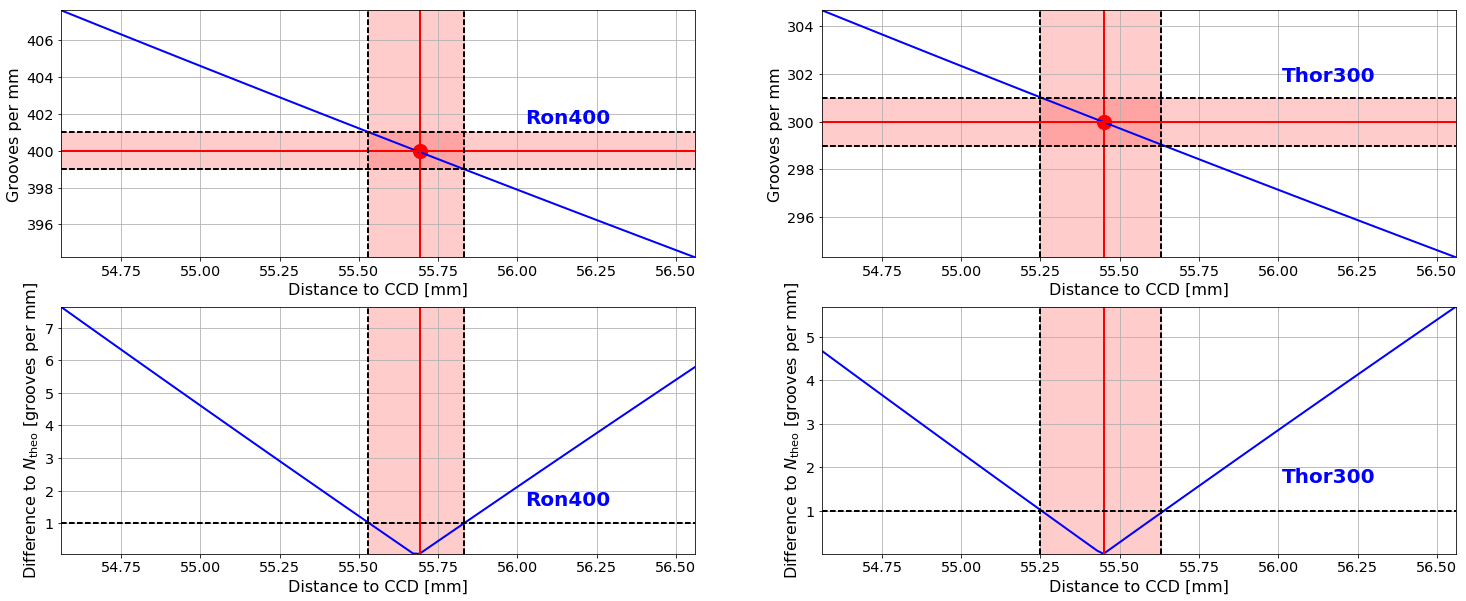

In [78]:
distance_mean, distance_mean_err = CalibrateDistance2CCD_TwoOrder(thecorrspectra,all_filt,leftorder_edges=[100,400],rightorder_edges=[1200,1600],guess=[[10,200,200],[10,1400,200]],bounds=(-np.inf,np.inf))

### Resolution of the gratings

With the +1 order

In [125]:
%autoreload 2
from holo_specs import *

def GratingResolution_OneOrder(thecorrspectra,thex0,all_images,all_filt,left_edge=1200,right_edge=1600,guess=[10,1400,200],bounds=(-np.inf,np.inf)):
    print 'H-alpha filter center: %.1fnm ' % (HALPHA_CENTER*1e6)
    print 'H-alpha filter width: %.1fnm\n' % (HALPHA_WIDTH*1e6)

    Ns = []
    N_errs = []
    for index in range(len(thecorrspectra)):
        # dispersion axis analysis
        spectra = thecorrspectra[index]
        popt, pcov = EmissionLineFit(spectra,left_edge,right_edge,guess,bounds)
        x0 = popt[1]
        # compute N
        deltaX = np.abs(x0 - thex0[index])
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD)
        N = np.sin(theta)/HALPHA_CENTER
        Ns.append(N)
        # compute N uncertainty 
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD+DISTANCE2CCD_ERR)
        N_up = np.sin(theta)/HALPHA_CENTER
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD-DISTANCE2CCD_ERR)
        N_low = np.sin(theta)/HALPHA_CENTER
        N_err = 0.5*np.abs(N_up-N_low)
        N_errs.append(N_err)
        # look at finesse
        fwhm_line = np.abs(popt[2])*2.355
        g = Grating(N,label=all_filt[index])
        res = g.grating_resolution(deltaX)
        finesse = HALPHA_CENTER/(res*fwhm_line*1e-6-HALPHA_WIDTH)
        # transverse profile analysis
        yprofile=np.copy(all_images[index])[:,int(x0)]
        popt2, pcov2 = EmissionLineFit(yprofile,0,len(yprofile),[500,100,10])
        fwhm_profile = np.abs(popt2[2])*2.355
        finesse_profile = HALPHA_CENTER*1e6/(res*fwhm_profile)
    
        print all_filt[index]
        print 'N=%.1f +/- %.1f lines/mm\t H-alpha FWHM=%.1fpix with res=%.3fnm/pix : FWHM=%.1fnm\t ie finesse=%.1f' % (N,N_err,fwhm_line,res,res*fwhm_line,finesse)
        print 'Transverse profile FWHM=%.1fpix ' % (fwhm_profile)
        print '-------------------------------'
    return(Ns,N_errs)

In [153]:
print DISTANCE2CCD
#DISTANCE2CCD= 55.56
#DISTANCE2CCD = 55.33
#HALPHA_CENTER = 655.9
#HALPHA_CENTER = 655.9e-6+1.3e-6

left_edge = 1200
right_edge = 1600
guess = [10,1400,200]
N_rightorder, N_rightorder_err = GratingResolution_OneOrder(thecorrspectra,thex0,all_images,all_filt,left_edge,right_edge,guess)

55.33
H-alpha filter center: 657.2nm 
H-alpha filter width: 6.4nm

Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
Ron400
N=401.0 +/- 1.1 lines/mm	 H-alpha FWHM=16.1pix with res=0.968nm/pix : FWHM=15.6nm	 ie finesse=71.5
Transverse profile FWHM=5.7pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
Thor300
N=299.2 +/- 0.9 lines/mm	 H-alpha FWHM=8.6pix with res=1.361nm/pix : FWHM=11.6nm	 ie finesse=125.6
Transverse profile FWHM=3.5pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.0 degrees
HoloPhP
N=355.0 +/- 1.0 lines/mm	 H-alpha FWHM=10.2pix with res=1.119nm/pix : FWHM=11.4nm	 ie finesse=130.7
Transverse profile FWHM=3.6pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -2.1 degrees
HoloPhAg
N=349.7 +/- 1.0 lines/mm	 H-alpha FWHM=7.7pix with res=1.138nm/pix 

With -1 order

In [81]:
left_edge = 100
right_edge = 400
guess=[10,200,100]
bounds=((50,300),(left_edge,right_edge),(1,30))
N_leftorder, N_leftorder_err = GratingResolution_OneOrder(thecorrspectra,thex0,all_images,all_filt,left_edge,right_edge,guess)

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
Ron400
N=401.4 +/- 1.1 lines/mm	 H-alpha FWHM=16.4pix with res=0.968nm/pix : FWHM=15.9nm	 ie finesse=69.0
Transverse profile FWHM=6.4pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
Thor300
N=300.2 +/- 0.9 lines/mm	 H-alpha FWHM=8.8pix with res=1.360nm/pix : FWHM=11.9nm	 ie finesse=118.6
Transverse profile FWHM=3.6pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.0 degrees
HoloPhP
N=355.8 +/- 1.0 lines/mm	 H-alpha FWHM=15.1pix with res=1.118nm/pix : FWHM=16.9nm	 ie finesse=62.3
Transverse profile FWHM=5.7pix 
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -2.1 degrees
HoloPhAg
N=351.2 +/- 1.0 lines/mm	 H-alpha FWHM=24.0pix with res=1.137nm/pix : FWHM

Mean of the results :

In [82]:
for index in range(len(all_filt)):
    print all_filt[index]
    Nr = N_rightorder[index]
    Nl = N_leftorder[index]
    Nr_err = N_rightorder_err[index]
    Nl_err = N_leftorder_err[index]
    N = np.mean([Nr,Nl])
    N_err = 0.5*np.sqrt(Nr_err**2+Nl_err**2)
    print 'Right: N=%.1f +/- %.1f lines/mm\t Left: N=%.1f +/- %.1f lines/mm\t Mean: N=%.1f +/- %.1f lines/mm' % (Nr,Nr_err,Nl,Nl_err,N,N_err)
    print '-------------------------------'


Ron400
Right: N=400.2 +/- 1.1 lines/mm	 Left: N=401.4 +/- 1.1 lines/mm	 Mean: N=400.8 +/- 0.8 lines/mm
-------------------------------
Thor300
Right: N=298.6 +/- 0.9 lines/mm	 Left: N=300.2 +/- 0.9 lines/mm	 Mean: N=299.4 +/- 0.6 lines/mm
-------------------------------
HoloPhP
Right: N=354.3 +/- 1.0 lines/mm	 Left: N=355.8 +/- 1.0 lines/mm	 Mean: N=355.1 +/- 0.7 lines/mm
-------------------------------
HoloPhAg
Right: N=349.0 +/- 1.0 lines/mm	 Left: N=351.2 +/- 1.0 lines/mm	 Mean: N=350.1 +/- 0.7 lines/mm
-------------------------------
HoloAmAg
Right: N=350.7 +/- 1.0 lines/mm	 Left: N=352.4 +/- 1.0 lines/mm	 Mean: N=351.5 +/- 0.7 lines/mm
-------------------------------


In [83]:
%autoreload 2
from holo_specs import *

def GratingResolution_TwoOrder(thecorrspectra,all_images,all_filt,leftorder_edges=[100,400],rightorder_edges=[1200,1600],guess=[[10,200,100],[10,1400,200]],bounds=(-np.inf,np.inf)):
    print 'H-alpha filter center: %.1fnm ' % (HALPHA_CENTER*1e6)
    print 'H-alpha filter width: %.1fnm\n' % (HALPHA_WIDTH*1e6)

    Ns = []
    N_errs = []
    for index in range(len(thecorrspectra)):
        # dispersion axis analysis
        spectra = thecorrspectra[index]
        popt, pcov = EmissionLineFit(spectra,leftorder_edges[0],leftorder_edges[1],guess[0],bounds)
        x0_left = popt[1]
        popt2, pcov = EmissionLineFit(spectra,rightorder_edges[0],rightorder_edges[1],guess[1],bounds)
        x0_right = popt2[1]
        deltaX = 0.5*np.abs(x0_left-x0_right)
        # compute N
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD)
        N = np.sin(theta)/HALPHA_CENTER
        Ns.append(N)
        # compute N uncertainty 
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD+DISTANCE2CCD_ERR)
        N_up = np.sin(theta)/HALPHA_CENTER
        theta = np.arctan2(deltaX*PIXEL2MM,DISTANCE2CCD-DISTANCE2CCD_ERR)
        N_low = np.sin(theta)/HALPHA_CENTER
        N_err = 0.5*np.abs(N_up-N_low)
        N_errs.append(N_err)
        # look at finesse
        g = Grating(N,label=all_filt[index])
        res = g.grating_resolution(deltaX)
        # right
        fwhm_line_right = np.abs(popt2[2])*2.355
        finesse_right = HALPHA_CENTER/(res*fwhm_line_right*1e-6-HALPHA_WIDTH)
        # left
        fwhm_line_left = np.abs(popt[2])*2.355
        finesse_left = HALPHA_CENTER/(res*fwhm_line_left*1e-6-HALPHA_WIDTH)
        # transverse profile analysis
        # right
        yprofile=np.copy(all_images[index])[:,int(x0_right)]
        popt2, pcov2 = EmissionLineFit(yprofile,0,len(yprofile),[500,100,10])
        fwhm_profile_right = np.abs(popt2[2])*2.355
        finesse_profile_right = HALPHA_CENTER*1e6/(res*fwhm_profile_right)
        # left
        yprofile=np.copy(all_images[index])[:,int(x0_left)]
        popt2, pcov2 = EmissionLineFit(yprofile,0,len(yprofile),[500,100,10])
        fwhm_profile_left = np.abs(popt2[2])*2.355
        finesse_profile_left = HALPHA_CENTER*1e6/(res*fwhm_profile_left)
    
        print all_filt[index]
        print 'N=%.1f +/- %.1f lines/mm' % (N,N_err)
        print 'Right order: H-alpha FWHM=%.1fpix with res=%.2gnm/pix : FWHM=%.1fnm\t ie finesse=%.1f' % (fwhm_line_right,res,res*fwhm_line_right,finesse_right)
        print 'Left  order: H-alpha FWHM=%.1fpix with res=%.2gnm/pix : FWHM=%.1fnm\t ie finesse=%.1f' % (fwhm_line_left,res,res*fwhm_line_left,finesse_left)
        print 'Transverse profile FWHM :  %.1fpix (right)  %.1fpix (left)' % (fwhm_profile_right, fwhm_profile_left)
        print '-------------------------------'
    return(Ns,N_errs)

In [84]:
Ns, N_errs = GratingResolution_TwoOrder(thecorrspectra,all_images,all_filt,leftorder_edges=[100,400],rightorder_edges=[1200,1600],guess=[[10,200,100],[10,1400,200]])

H-alpha filter center: 655.9nm 
H-alpha filter width: 6.4nm

Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
Ron400
N=400.8 +/- 1.1 lines/mm
Right order: H-alpha FWHM=16.1pix with res=0.97nm/pix : FWHM=15.6nm	 ie finesse=71.4
Left  order: H-alpha FWHM=16.4pix with res=0.97nm/pix : FWHM=15.9nm	 ie finesse=69.0
Transverse profile FWHM :  5.7pix (right)  6.4pix (left)
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
Thor300
N=299.4 +/- 0.9 lines/mm
Right order: H-alpha FWHM=8.6pix with res=1.4nm/pix : FWHM=11.6nm	 ie finesse=125.4
Left  order: H-alpha FWHM=8.8pix with res=1.4nm/pix : FWHM=11.9nm	 ie finesse=118.6
Transverse profile FWHM :  3.5pix (right)  3.6pix (left)
-------------------------------
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.0 degrees
HoloPhP
N=355.1 +/- 1.0 lines/mm
Right order: H-alpha FWHM=10.2pix with res=1.1nm/pix : FWHM=11.4nm	

In [85]:
holos = []
for i in range(5):
    holos.append(Hologram(all_filt[i]))

Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.3 degrees
N = 400.82 +/- 1.14 grooves/mm
Hologram center at x0 = 741.0 and y0 = 741.0 with average tilt of -0.3 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.3 degrees
Order  0 position at x0 = 475.4 and y0 = 742.3
Order +1 position at x0 = 1006.6 and y0 = 739.7
Distance between the orders: 531.21 pixels (12.75 mm)
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -0.6 degrees
N = 299.41 +/- 0.88 grooves/mm
Hologram center at x0 = 1398.0 and y0 = 1264.0 with average tilt of -0.6 degrees
Plate center at x0 = 774.0 and y0 = 690.7 with average tilt of -0.6 degrees
Order  0 position at x0 = 1132.4 and y0 = 1266.7
Order +1 position at x0 = 1663.6 and y0 = 1261.3
Distance between the orders: 531.21 pixels (12.75 mm)
Grating plate center at x0 = 1024.0 and y0 = 1024.0 with average tilt of -1.0 degrees
N = 355.08 +/- 1.03 grooves/mm
Hologram center at x0 = 843.0 and y0

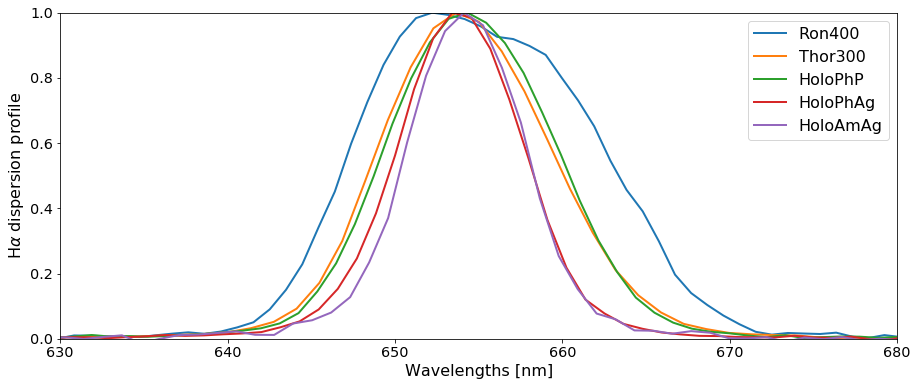

In [86]:
import sys
sys.path.append("../../common_tools/")
from scan_holo import *

left_edge = 1200
right_edge = 1600

fig, ax = plt.subplots(1,1,figsize=(15,6))
for i in range(5):
    profile = thecorrspectra[i]
    lambdas = holos[i].grating_pixel_to_lambda(np.arange(len(profile)) -thex0[i] ) 
    ax.plot(lambdas,np.array(profile)/np.max(profile[left_edge:right_edge]),label=all_filt[i],lw=2)
#plot_atomic_lines(ax,np.max(profile[1])*1.2,redshift=0,atmospheric_lines=True)
ax.set_xlabel('Wavelengths [nm]',fontsize=16)
ax.set_ylabel('H$\\alpha$ dispersion profile',fontsize=16)
ax.set_ylim([0,1])
ax.set_xlim([630,680])
ax.legend(fontsize=16)
figfilename=os.path.join(dir_top_images,'Halpha_profiles.pdf')
plt.savefig(figfilename, bbox_inches='tight', rasterized=True, dpi=300)  
plt.show()

### Main conclusions

- The distance to CCD has been recalibrated using the two orders from the Ronchi 400 and Thorlabs 300 gratings
- The hologram effective grooves per mm number is computed using the two orders and is approximately 350+/-1
- FWHMs are better on the +1 order and finesse is better for holograms than gratings. Among holograms HoloPhP is less performant

## Save results

In [87]:
for index in range(len(all_filt)):
    holo_name = all_filt[index]
    dirname = "../../common_tools/data/"+holo_name
    ensure_dir(dirname)
    print 'Save results in ',dirname
    np.savetxt(dirname+'/N.txt',[Ns[index],N_errs[index]])

Save results in  ../../common_tools/data/Ron400
Save results in  ../../common_tools/data/Thor300
Save results in  ../../common_tools/data/HoloPhP
Save results in  ../../common_tools/data/HoloPhAg
Save results in  ../../common_tools/data/HoloAmAg


In [88]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^rotimg_(.*)',short_infilename)
    short_outfilename='finalSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [89]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_20170531_051.fits',
 './spectrum_fitsspec/finalSpectra_20170531_052.fits',
 './spectrum_fitsspec/finalSpectra_20170531_053.fits',
 './spectrum_fitsspec/finalSpectra_20170531_054.fits',
 './spectrum_fitsspec/finalSpectra_20170531_055.fits']

### Save outputfilename

In [90]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='RawLeftSpec',format='E',array=spectra_left[idx[0]])
    col2=fits.Column(name='RawRightSpec',format='E',array=spectra_right[idx[0]])
    cols=fits.ColDefs([col1,col2])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)

NameError: name 'spectra_left' is not defined